In [1]:
import pandas as pd
from sklearn import datasets
import numpy as np
from sklearn.preprocessing import StandardScaler
from factor_analyzer import FactorAnalyzer
from sklearn.decomposition import FactorAnalysis, PCA
import matplotlib.pyplot as plt
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer.factor_analyzer import calculate_kmo
import missingno as msno
import seaborn as sns
import yfinance as yf

# Traget Engineering/EDA

This project is focused on possible downtruns for indivdiaul stocks purchases over different time intervals. To develop the targets, I pulled the last three years of price history for each ticker of the S&P 500 and compared closing prices over periods of 260 buissness days(1 year), 22 buissness days(1 month), and 5 buissness days(1 week). I then took took the average of the 5% worst returns. Below is an example of ticker for Microsoft. 

In [2]:
msft = yf.Ticker('MSFT')

In [3]:
history = msft.history(period='3y')

In [4]:
history

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2019-12-03,143.387191,145.273212,142.570546,145.156555,24066000,0.0,0
2019-12-04,145.963491,146.002372,145.049637,145.681564,17574700,0.0,0
2019-12-05,145.875965,146.138458,145.321814,145.759293,17869100,0.0,0
2019-12-06,146.789833,147.645344,146.089861,147.528687,16403500,0.0,0
2019-12-09,146.867625,147.975912,146.712072,147.149551,16687400,0.0,0
...,...,...,...,...,...,...,...
2022-11-28,246.080002,246.649994,240.800003,241.759995,24778200,0.0,0
2022-11-29,241.399994,242.789993,238.210007,240.330002,17956300,0.0,0
2022-11-30,240.570007,255.330002,239.860001,255.139999,47594200,0.0,0


In [7]:
pip install dataframe-image

Note: you may need to restart the kernel to use updated packages.


In [12]:
import dataframe_image as dfi

In [14]:
dfi.export(history[0:50], 'frame.png')

For the return over year, I divided the slice of the last 2 years by the first 2 years and divided by the slice of the first two years. This gives the % return overs 260 buissness days or one year. I used similiar method for month and week returns. I then I considered the target as the .05 quantile a typical very negative scenario.

In [5]:
history['Close'][:-260]

Date
2019-10-28    140.097321
2019-10-29    138.775940
2019-10-30    140.505402
2019-10-31    139.300568
2019-11-01    139.640640
                 ...    
2021-10-07    292.401154
2021-10-08    292.401154
2021-10-11    291.786316
2021-10-12    290.447479
2021-10-13    293.848999
Name: Close, Length: 495, dtype: float64

In [6]:
year_returns = (history['Close'][260:].to_numpy() - history['Close'][:-260].to_numpy())/history['Close'][:-260].to_numpy()

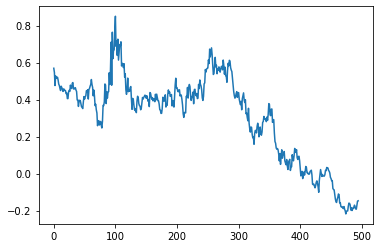

In [7]:
plt.plot(year_returns)

In [8]:
np.quantile(year_returns, .05)

-0.16340503019587602

In [9]:
month_closings = (history['Close'][22:].to_numpy() - history['Close'][:-22].to_numpy())/history['Close'][:-22].to_numpy()

In [10]:
np.quantile(month_closings, .05)

-0.113825947278241

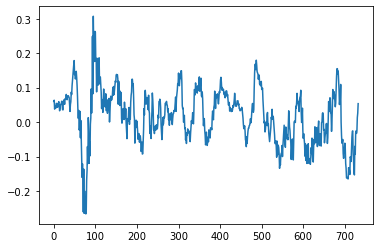

In [11]:
plt.plot(month_closings)

In [12]:
weekly_closings = (history['Close'][5:].to_numpy() - history['Close'][:-5].to_numpy())/history['Close'][:-5].to_numpy()

In [13]:
np.quantile(weekly_closings, .05)

-0.0634009784968086

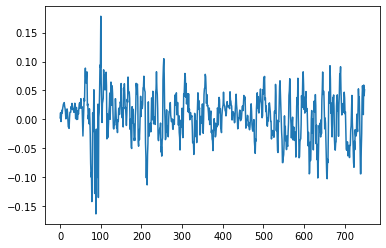

In [14]:
plt.plot(weekly_closings)

# Pulling Attributes

The target variable is pulled from the means of the last three years. Therefore all attributes will be pulled from before this time. The Yahoo Finance API typically returns financial data for the last four years. Therefore 2019 is the typical year financial data is pulled from. Also volatility will be caclulated from before 2019. 

## Volatility calculation.

In [15]:
history = msft.history(period='8y')

In [16]:
history

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2014-10-27,39.756681,40.095887,39.756681,39.930634,30371300,0.0,0
2014-10-28,39.887151,40.443797,39.808873,40.435101,29049800,0.0,0
2014-10-29,40.391611,40.617751,40.304637,40.548168,30276100,0.0,0
2014-10-30,40.287238,40.287238,39.808871,40.052402,30073900,0.0,0
2014-10-31,40.826490,40.852585,40.426402,40.835190,35849700,0.0,0
...,...,...,...,...,...,...,...
2022-10-19,237.039993,239.610001,234.289993,236.479996,19985700,0.0,0
2022-10-20,235.770004,241.309998,234.869995,236.149994,21811000,0.0,0
2022-10-21,234.740005,243.000000,234.500000,242.119995,26280900,0.0,0


In [17]:
history = history[:'2019-01-01']

In [18]:
history

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2014-10-27,39.756681,40.095887,39.756681,39.930634,30371300,0.0,0
2014-10-28,39.887151,40.443797,39.808873,40.435101,29049800,0.0,0
2014-10-29,40.391611,40.617751,40.304637,40.548168,30276100,0.0,0
2014-10-30,40.287238,40.287238,39.808871,40.052402,30073900,0.0,0
2014-10-31,40.826490,40.852585,40.426402,40.835190,35849700,0.0,0
...,...,...,...,...,...,...,...
2018-12-24,93.842837,94.121446,90.288187,90.432289,43935200,0.0,0
2018-12-26,91.402618,96.734601,90.268972,96.609703,51634800,0.0,0
2018-12-27,95.399177,97.214931,92.613097,97.205322,49498500,0.0,0


In [19]:
volatility = history['Close'].var()

In [20]:
volatility

472.2754102357124

## Gathering other attributes

I each ticker I wanted to put all attributes into a single DataFrame that could be appeneded onto a main DataFrame. This required some transpositions to get all the data in a usable format.

In [21]:
msft.get_cashflow()

,2022-06-30,2021-06-30,2020-06-30,2019-06-30
Investments,1.843800e+10,2.876000e+09,6.980000e+09,5.400000e+08
Change To Liabilities,8.052000e+09,7.431000e+09,5.230000e+09,4.694000e+09
Total Cashflows From Investing Activities,-3.031100e+10,-2.757700e+10,-1.222300e+10,-1.577300e+10
Net Borrowings,-9.023000e+09,-3.750000e+09,-5.518000e+09,-4.000000e+09
Total Cash From Financing Activities,-5.887600e+10,-4.848600e+10,-4.603100e+10,-3.688700e+10
Change To Operating Activities,-3.450000e+08,1.160000e+09,-6.730000e+08,-1.542000e+09
Issuance Of Stock,1.841000e+09,1.693000e+09,1.343000e+09,1.142000e+09
Net Income,7.273800e+10,6.127100e+10,4.428100e+10,3.924000e+10
Change In Cash,-2.930000e+08,6.480000e+08,2.220000e+09,-5.900000e+08
Repurchase Of Stock,-3.269600e+10,-2.738500e+10,-2.296800e+10,-1.954300e+10


In [22]:
msft.get_balance_sheet()

,2022-06-30,2021-06-30,2020-06-30,2019-06-30
Intangible Assets,1.129800e+10,7.800000e+09,7.038000e+09,7.750000e+09
Total Liab,1.982980e+11,1.917910e+11,1.830070e+11,1.842260e+11
Total Stockholder Equity,1.665420e+11,1.419880e+11,1.183040e+11,1.023300e+11
Other Current Liab,5.938400e+10,5.261200e+10,4.600100e+10,4.586000e+10
Total Assets,3.648400e+11,3.337790e+11,3.013110e+11,2.865560e+11
Common Stock,8.693900e+10,8.311100e+10,8.055200e+10,7.852000e+10
Other Current Assets,1.693200e+10,1.347100e+10,1.151700e+10,1.013300e+10
Retained Earnings,8.428100e+10,5.705500e+10,3.456600e+10,2.415000e+10
Other Liab,3.085300e+10,3.168100e+10,3.449200e+10,3.569900e+10
Good Will,6.752400e+10,4.971100e+10,4.335100e+10,4.202600e+10


In [23]:
msft.get_earnings()

,Revenue,Earnings
Year,,
2019,125843000000,39240000000
2020,143015000000,44281000000
2021,168088000000,61271000000
2022,198270000000,72738000000


In [24]:
attribute_list = ['volatility']

In [25]:
attribute_list += msft.get_cashflow().transpose().columns.values.tolist()

In [26]:
attribute_list += msft.get_balance_sheet().transpose().columns.values.tolist()

In [27]:
attribute_list += msft.get_earnings().columns.values.tolist()

In [28]:
attribute_list

['volatility',
 'Investments',
 'Change To Liabilities',
 'Total Cashflows From Investing Activities',
 'Net Borrowings',
 'Total Cash From Financing Activities',
 'Change To Operating Activities',
 'Issuance Of Stock',
 'Net Income',
 'Change In Cash',
 'Repurchase Of Stock',
 'Effect Of Exchange Rate',
 'Total Cash From Operating Activities',
 'Depreciation',
 'Other Cashflows From Investing Activities',
 'Dividends Paid',
 'Change To Inventory',
 'Change To Account Receivables',
 'Other Cashflows From Financing Activities',
 'Change To Netincome',
 'Capital Expenditures',
 'Intangible Assets',
 'Total Liab',
 'Total Stockholder Equity',
 'Other Current Liab',
 'Total Assets',
 'Common Stock',
 'Other Current Assets',
 'Retained Earnings',
 'Other Liab',
 'Good Will',
 'Treasury Stock',
 'Other Assets',
 'Cash',
 'Total Current Liabilities',
 'Deferred Long Term Asset Charges',
 'Short Long Term Debt',
 'Other Stockholder Equity',
 'Property Plant Equipment',
 'Total Current Assets',

In [29]:
stock_data_frame = pd.DataFrame(columns=attribute_list)

In [30]:
stock_data_frame

,volatility,Investments,Change To Liabilities,Total Cashflows From Investing Activities,Net Borrowings,Total Cash From Financing Activities,Change To Operating Activities,Issuance Of Stock,Net Income,Change In Cash,...,Total Current Assets,Long Term Investments,Net Tangible Assets,Short Term Investments,Net Receivables,Long Term Debt,Inventory,Accounts Payable,Revenue,Earnings


In [31]:
cashflow_values = msft.get_cashflow().iloc[:,-1].transpose().tolist()

In [32]:
len(cashflow_values)

20

In [33]:
balance_sheet_values = msft.get_balance_sheet().iloc[:,-1].values.tolist()

In [34]:
len(balance_sheet_values)

26

In [35]:
earnings_values = msft.get_earnings().iloc[0].values.tolist()

In [36]:
earnings_values

[125843000000, 39240000000]

In [37]:
all_values = [volatility] + cashflow_values + balance_sheet_values + earnings_values

In [38]:
stock_data_frame.loc['MSFT'] = all_values

In [39]:
stock_data_frame

,volatility,Investments,Change To Liabilities,Total Cashflows From Investing Activities,Net Borrowings,Total Cash From Financing Activities,Change To Operating Activities,Issuance Of Stock,Net Income,Change In Cash,...,Total Current Assets,Long Term Investments,Net Tangible Assets,Short Term Investments,Net Receivables,Long Term Debt,Inventory,Accounts Payable,Revenue,Earnings
MSFT,472.27541,540000000.0,4.694000e+09,-1.577300e+10,-4.000000e+09,-3.688700e+10,-1.542000e+09,1.142000e+09,3.924000e+10,-590000000.0,...,1.755520e+11,2.649000e+09,5.255400e+10,1.224760e+11,2.952400e+10,6.666200e+10,2.063000e+09,9.382000e+09,1.258430e+11,3.924000e+10


This DataFrame is an example of one row from the main DataFrame that will hold stock data. This process will be repeated to get one master DataFrame of available stock data.

In [40]:
stock_tickers = pd.read_csv('Stocks in the SP 500 Index.csv')

In [41]:
stock_tickers = stock_tickers['Symbol'].values.tolist()

In [42]:
df = pd.DataFrame()

In [43]:
stock_list = []

Pulling data for each ticker.

In [44]:
for ticker in stock_tickers:
    stock_list.append(yf.Ticker(ticker))
    

In [45]:
stock_list

[yfinance.Ticker object <AAPL>,
 yfinance.Ticker object <MSFT>,
 yfinance.Ticker object <GOOG>,
 yfinance.Ticker object <GOOGL>,
 yfinance.Ticker object <AMZN>,
 yfinance.Ticker object <TSLA>,
 yfinance.Ticker object <BRK.B>,
 yfinance.Ticker object <UNH>,
 yfinance.Ticker object <JNJ>,
 yfinance.Ticker object <XOM>,
 yfinance.Ticker object <META>,
 yfinance.Ticker object <WMT>,
 yfinance.Ticker object <JPM>,
 yfinance.Ticker object <CVX>,
 yfinance.Ticker object <LLY>,
 yfinance.Ticker object <PG>,
 yfinance.Ticker object <V>,
 yfinance.Ticker object <NVDA>,
 yfinance.Ticker object <HD>,
 yfinance.Ticker object <MA>,
 yfinance.Ticker object <BAC>,
 yfinance.Ticker object <ABBV>,
 yfinance.Ticker object <PFE>,
 yfinance.Ticker object <KO>,
 yfinance.Ticker object <MRK>,
 yfinance.Ticker object <PEP>,
 yfinance.Ticker object <COST>,
 yfinance.Ticker object <TMO>,
 yfinance.Ticker object <DHR>,
 yfinance.Ticker object <MCD>,
 yfinance.Ticker object <ABT>,
 yfinance.Ticker object <ORCL>,


Not all stocks will contain all the data needed. Therefore some stocks will be ignored in try catch clause. This is nessary since not all companies have a long financial history or don't release all data. These stocks would not be considered in the final product website anyways.

In [46]:
counter = 0

In [47]:
"""
for stock in stock_list:
    
    try:
        
        price_history = stock.history(period='8y')
        target_history = price_history['2019-01-01':]
        history_attribute = price_history[:'2019-01-01']

        attribute_list = ['volatility']
        attribute_list += stock.get_cashflow().transpose().columns.values.tolist()
        attribute_list += stock.get_balance_sheet().transpose().columns.values.tolist()
        attribute_list += stock.get_earnings().columns.values.tolist()
        attribute_list += ['One Year Change', 'One Month Change', 'One Week Change']

        stock_data_frame = pd.DataFrame(columns = attribute_list)

        cashflow_values = stock.get_cashflow().iloc[:,-1].values.tolist()
        balance_sheet_values = stock.get_balance_sheet().iloc[:,-1].values.tolist()
        earnings_values = stock.get_earnings().iloc[0].values.tolist()

        volatility = history_attribute['Close'].var()/history_attribute['Close'].mean()

        year_returns = (target_history['Close'][260:].to_numpy() - target_history['Close'][:-260].to_numpy())/target_history['Close'][:-260].to_numpy()
        month_closings = (target_history['Close'][22:].to_numpy() - target_history['Close'][:-22].to_numpy())/target_history['Close'][:-22].to_numpy()
        weekly_closings = (target_history['Close'][5:].to_numpy() - target_history['Close'][:-5].to_numpy())/target_history['Close'][:-5].to_numpy()

        targets = [np.quantile(year_returns, .05), np.quantile(month_closings, .05), np.quantile(weekly_closings, .05)]

        all_values = [volatility] + cashflow_values + balance_sheet_values + earnings_values + targets

        stock_data_frame.loc[stock.ticker] = all_values

        df = pd.concat([df,stock_data_frame])
        
    except:
        
        print(stock)
        
    counter += 1
    
    print(counter)

"""
    

"\nfor stock in stock_list:\n    \n    try:\n        \n        price_history = stock.history(period='8y')\n        target_history = price_history['2019-01-01':]\n        history_attribute = price_history[:'2019-01-01']\n\n        attribute_list = ['volatility']\n        attribute_list += stock.get_cashflow().transpose().columns.values.tolist()\n        attribute_list += stock.get_balance_sheet().transpose().columns.values.tolist()\n        attribute_list += stock.get_earnings().columns.values.tolist()\n        attribute_list += ['One Year Change', 'One Month Change', 'One Week Change']\n\n        stock_data_frame = pd.DataFrame(columns = attribute_list)\n\n        cashflow_values = stock.get_cashflow().iloc[:,-1].values.tolist()\n        balance_sheet_values = stock.get_balance_sheet().iloc[:,-1].values.tolist()\n        earnings_values = stock.get_earnings().iloc[0].values.tolist()\n\n        volatility = history_attribute['Close'].var()/history_attribute['Close'].mean()\n\n        ye

In [48]:
df

""


In [49]:
#df.to_csv('all_data.csv')

In [50]:
#df.to_csv('all_data1.csv')

In [51]:
df = pd.read_csv('all_data.csv')

In [52]:
df

,Unnamed: 0,volatility,Investments,Change To Liabilities,Total Cashflows From Investing Activities,Net Borrowings,Total Cash From Financing Activities,Change To Operating Activities,Issuance Of Stock,Net Income,...,One Year Change,One Month Change,One Week Change,Effect Of Exchange Rate,Intangible Assets,Good Will,Deferred Long Term Asset Charges,Capital Surplus,Minority Interest,Deferred Long Term Liab
0,AAPL,2.369968,3.084500e+10,9.172000e+09,1.606600e+10,4.320000e+08,-8.787600e+10,3.001600e+10,6.690000e+08,5.953100e+10,...,0.050251,-0.121304,-0.060047,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,MSFT,7.524141,5.400000e+08,4.694000e+09,-1.577300e+10,-4.000000e+09,-3.688700e+10,-1.542000e+09,1.142000e+09,3.924000e+10,...,-0.111706,-0.102336,-0.054914,-115000000.0,7.750000e+09,4.202600e+10,7.536000e+09,NaN,NaN,NaN
2,GOOG,2.636179,-1.972000e+09,1.438000e+09,-2.850400e+10,-6.100000e+07,-1.317900e+10,7.890000e+09,NaN,3.073600e+10,...,-0.203978,-0.130209,-0.062179,-302000000.0,2.220000e+09,1.788800e+10,7.370000e+08,NaN,NaN,NaN
3,GOOGL,2.542476,-1.972000e+09,1.438000e+09,-2.850400e+10,-6.100000e+07,-1.317900e+10,7.890000e+09,NaN,3.073600e+10,...,-0.203751,-0.128869,-0.063036,-302000000.0,2.220000e+09,1.788800e+10,7.370000e+08,NaN,NaN,NaN
4,AMZN,11.836587,1.140000e+09,4.414000e+09,-1.236900e+10,-7.686000e+09,-7.686000e+09,4.720000e+08,NaN,1.007300e+10,...,-0.332468,-0.129432,-0.075104,-351000000.0,4.110000e+09,1.454800e+10,NaN,2.679100e+10,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
471,BBWI,3.733131,NaN,2.900000e+07,-6.090000e+08,7.000000e+06,-8.720000e+08,1.280000e+08,1.000000e+06,6.440000e+08,...,-0.512504,-0.289205,-0.110921,2000000.0,4.110000e+08,1.348000e+09,6.200000e+07,7.710000e+08,4000000.0,NaN
472,FRT,0.672664,3.723600e+07,2.650000e+06,-1.922470e+08,-5.762000e+07,-2.413090e+08,2.422000e+07,1.309180e+08,2.419070e+08,...,-0.429384,-0.140825,-0.076647,NaN,1.528500e+07,NaN,NaN,3.004442e+09,257647000.0,NaN
473,FBHS,1.099194,-2.870000e+07,2.100000e+07,-6.343000e+08,8.262000e+08,-6.800000e+06,-2.950000e+07,4.900000e+06,3.896000e+08,...,-0.372632,-0.140401,-0.070104,-15200000.0,1.246800e+09,2.080300e+09,1.190000e+07,2.766000e+09,1800000.0,NaN
474,LUMN,0.420448,NaN,1.240000e+08,-3.078000e+09,-1.661000e+09,-4.023000e+09,-1.930000e+08,NaN,-1.733000e+09,...,-0.236360,-0.204833,-0.093782,NaN,1.077900e+10,2.803100e+10,NaN,2.285200e+10,NaN,2.600000e+08


In [53]:
df = df.drop(columns=['Unnamed: 0'])

In [54]:
df

,volatility,Investments,Change To Liabilities,Total Cashflows From Investing Activities,Net Borrowings,Total Cash From Financing Activities,Change To Operating Activities,Issuance Of Stock,Net Income,Change In Cash,...,One Year Change,One Month Change,One Week Change,Effect Of Exchange Rate,Intangible Assets,Good Will,Deferred Long Term Asset Charges,Capital Surplus,Minority Interest,Deferred Long Term Liab
0,2.369968,3.084500e+10,9.172000e+09,1.606600e+10,4.320000e+08,-8.787600e+10,3.001600e+10,6.690000e+08,5.953100e+10,5.624000e+09,...,0.050251,-0.121304,-0.060047,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,7.524141,5.400000e+08,4.694000e+09,-1.577300e+10,-4.000000e+09,-3.688700e+10,-1.542000e+09,1.142000e+09,3.924000e+10,-5.900000e+08,...,-0.111706,-0.102336,-0.054914,-115000000.0,7.750000e+09,4.202600e+10,7.536000e+09,NaN,NaN,NaN
2,2.636179,-1.972000e+09,1.438000e+09,-2.850400e+10,-6.100000e+07,-1.317900e+10,7.890000e+09,NaN,3.073600e+10,5.986000e+09,...,-0.203978,-0.130209,-0.062179,-302000000.0,2.220000e+09,1.788800e+10,7.370000e+08,NaN,NaN,NaN
3,2.542476,-1.972000e+09,1.438000e+09,-2.850400e+10,-6.100000e+07,-1.317900e+10,7.890000e+09,NaN,3.073600e+10,5.986000e+09,...,-0.203751,-0.128869,-0.063036,-302000000.0,2.220000e+09,1.788800e+10,7.370000e+08,NaN,NaN,NaN
4,11.836587,1.140000e+09,4.414000e+09,-1.236900e+10,-7.686000e+09,-7.686000e+09,4.720000e+08,NaN,1.007300e+10,1.031700e+10,...,-0.332468,-0.129432,-0.075104,-351000000.0,4.110000e+09,1.454800e+10,NaN,2.679100e+10,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
471,3.733131,NaN,2.900000e+07,-6.090000e+08,7.000000e+06,-8.720000e+08,1.280000e+08,1.000000e+06,6.440000e+08,-1.020000e+08,...,-0.512504,-0.289205,-0.110921,2000000.0,4.110000e+08,1.348000e+09,6.200000e+07,7.710000e+08,4000000.0,NaN
472,0.672664,3.723600e+07,2.650000e+06,-1.922470e+08,-5.762000e+07,-2.413090e+08,2.422000e+07,1.309180e+08,2.419070e+08,8.313200e+07,...,-0.429384,-0.140825,-0.076647,NaN,1.528500e+07,NaN,NaN,3.004442e+09,257647000.0,NaN
473,1.099194,-2.870000e+07,2.100000e+07,-6.343000e+08,8.262000e+08,-6.800000e+06,-2.950000e+07,4.900000e+06,3.896000e+08,-5.230000e+07,...,-0.372632,-0.140401,-0.070104,-15200000.0,1.246800e+09,2.080300e+09,1.190000e+07,2.766000e+09,1800000.0,NaN
474,0.420448,NaN,1.240000e+08,-3.078000e+09,-1.661000e+09,-4.023000e+09,-1.930000e+08,NaN,-1.733000e+09,-6.900000e+07,...,-0.236360,-0.204833,-0.093782,NaN,1.077900e+10,2.803100e+10,NaN,2.285200e+10,NaN,2.600000e+08


# Data Cleaning

<AxesSubplot:>

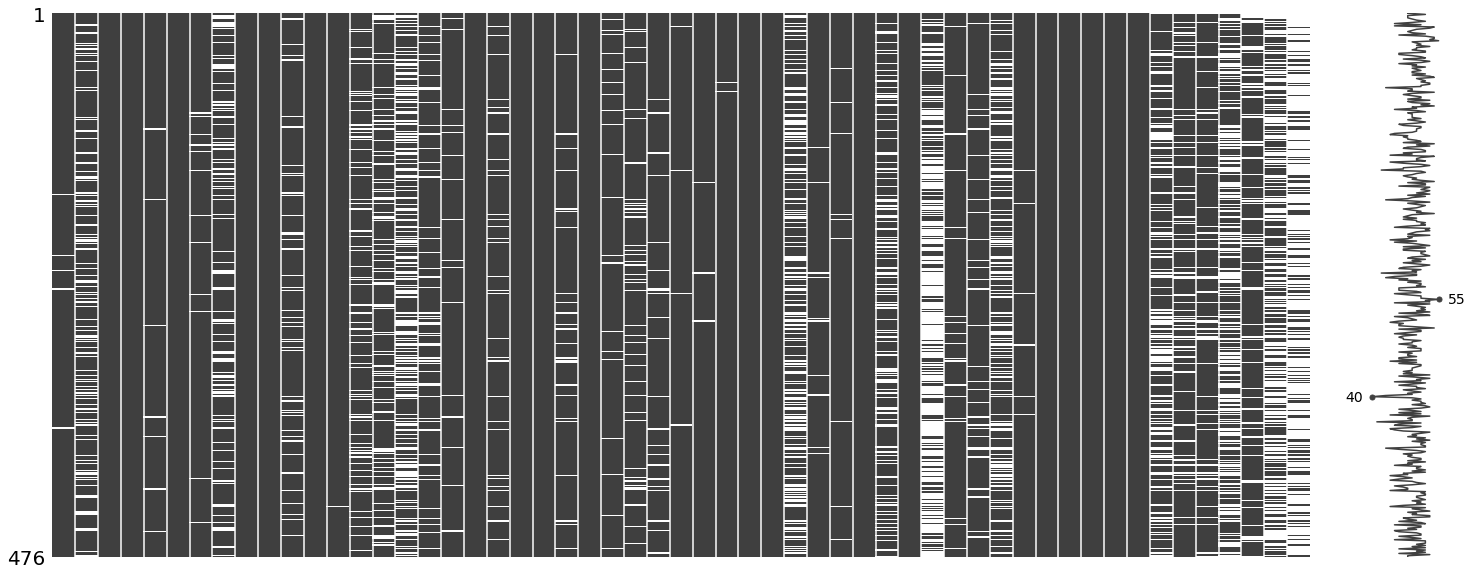

In [55]:
msno.matrix(df)

In [56]:
for column in df.columns:
    
    if df[column].isna().sum() > 100:
    
        df = df.drop(columns=[column])

<AxesSubplot:>

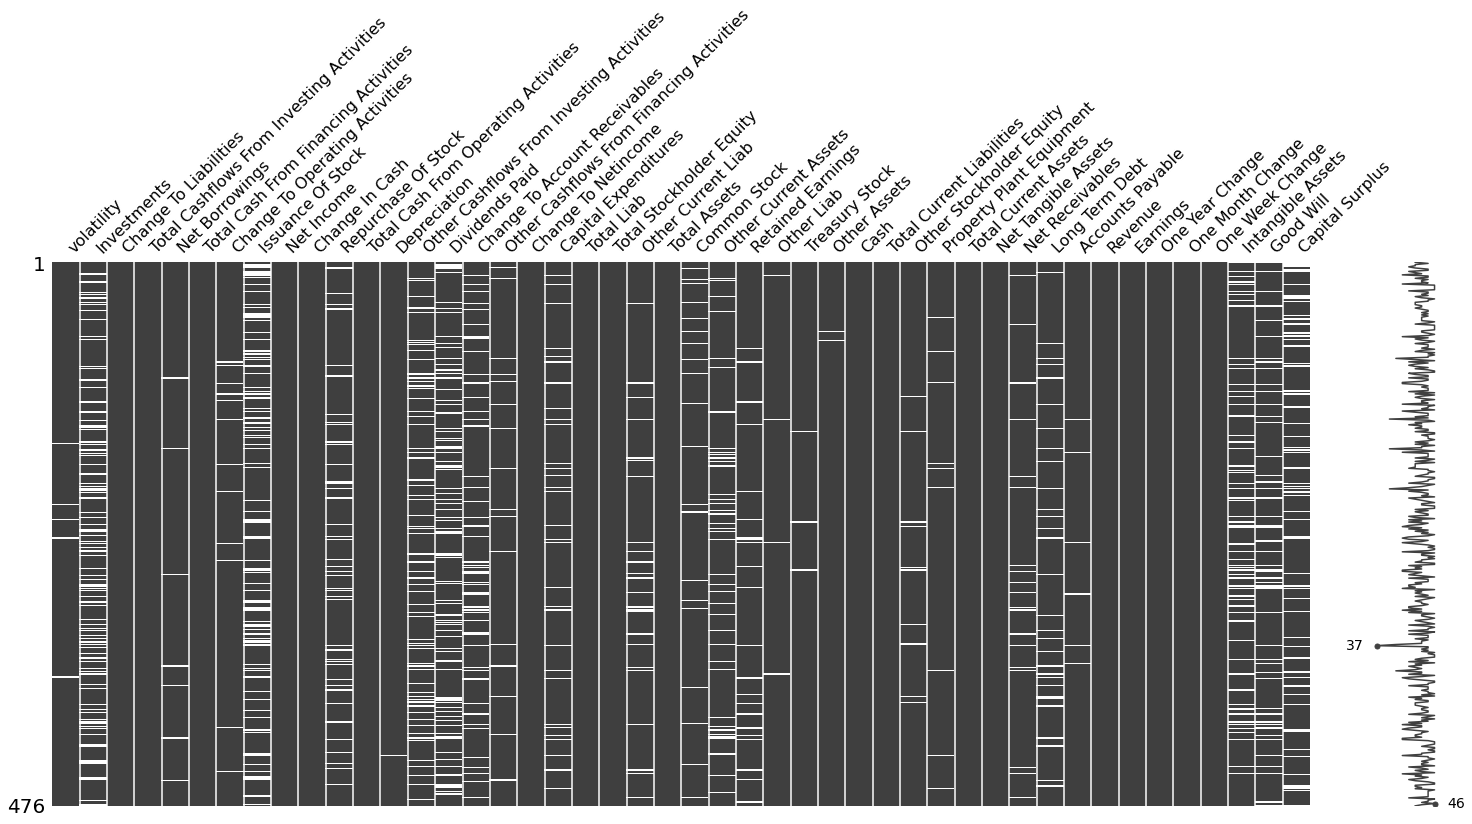

In [57]:
msno.matrix(df)

In [58]:
df['Investments'].isna().sum()

94

In [59]:
for column in df.columns:
    
    na = df[column].isna().sum()
    
    if na > 0:
    
        print("{}:{}".format(column, na))

volatility:6
Investments:94
Net Borrowings:7
Change To Operating Activities:12
Issuance Of Stock:94
Repurchase Of Stock:45
Depreciation:1
Other Cashflows From Investing Activities:67
Dividends Paid:85
Change To Account Receivables:54
Other Cashflows From Financing Activities:17
Capital Expenditures:32
Other Current Liab:26
Common Stock:21
Other Current Assets:41
Retained Earnings:24
Other Liab:4
Treasury Stock:3
Other Assets:2
Other Stockholder Equity:11
Property Plant Equipment:9
Net Receivables:20
Long Term Debt:30
Accounts Payable:6
Intangible Assets:67
Good Will:53
Capital Surplus:73


volatility:6


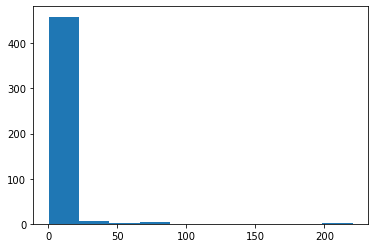

Investments:94


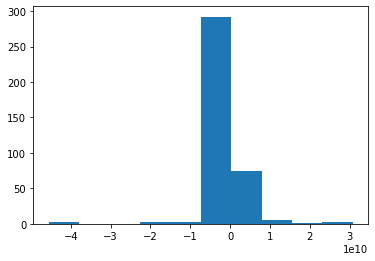

Net Borrowings:7


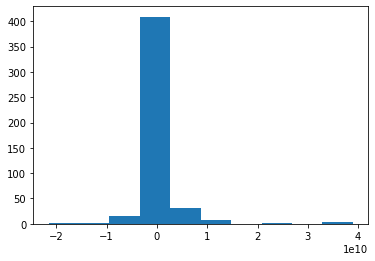

Change To Operating Activities:12


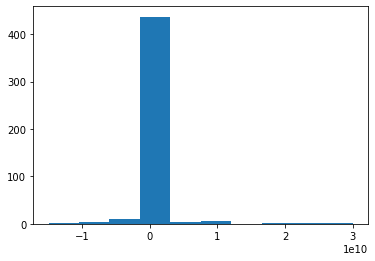

Issuance Of Stock:94


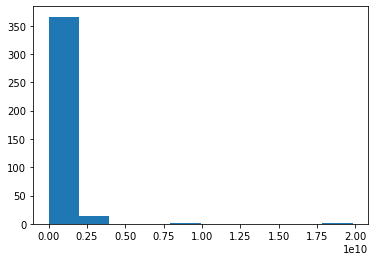

Repurchase Of Stock:45


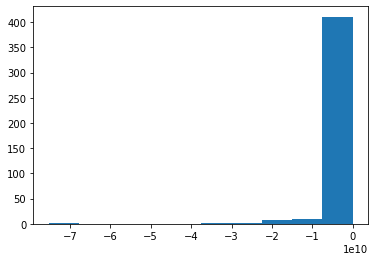

Depreciation:1


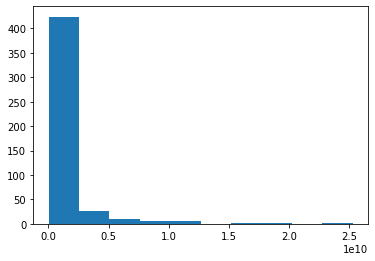

Other Cashflows From Investing Activities:67


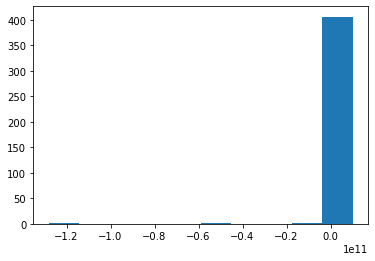

Dividends Paid:85


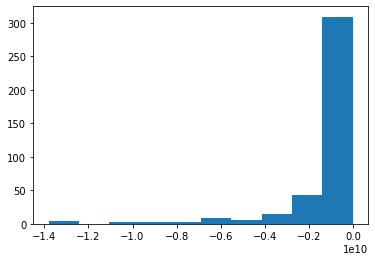

Change To Account Receivables:54


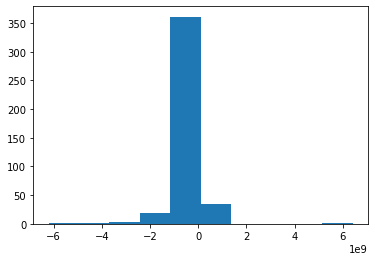

Other Cashflows From Financing Activities:17


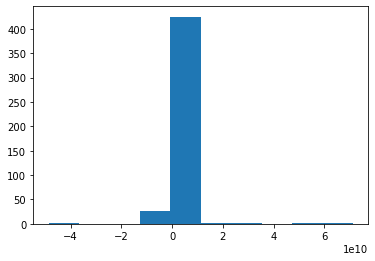

Capital Expenditures:32


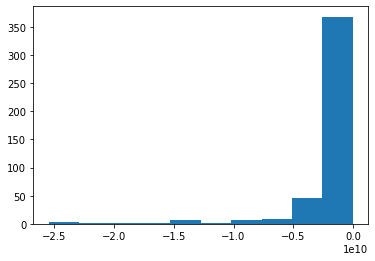

Other Current Liab:26


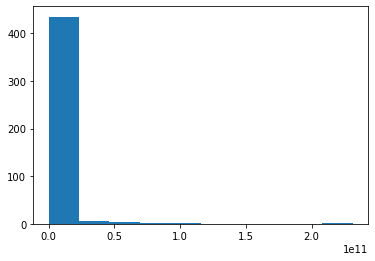

Common Stock:21


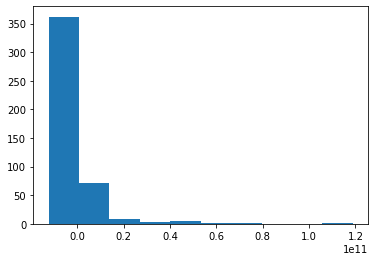

Other Current Assets:41


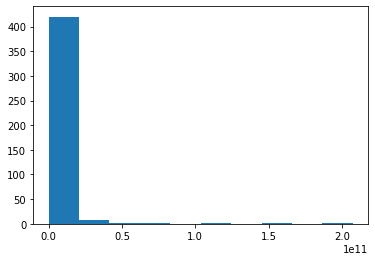

Retained Earnings:24


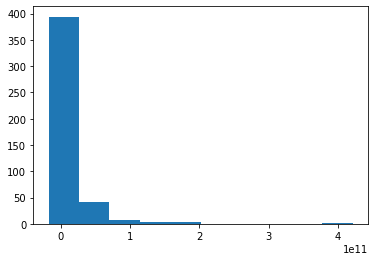

Other Liab:4


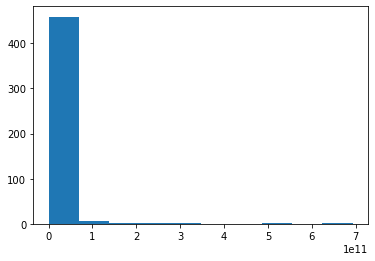

Treasury Stock:3


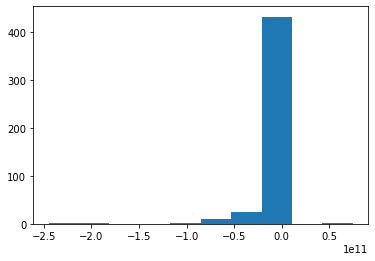

Other Assets:2


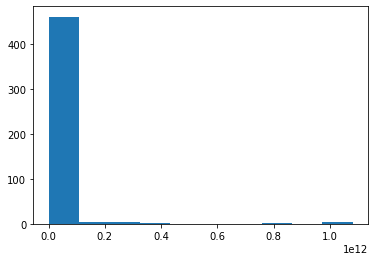

Other Stockholder Equity:11


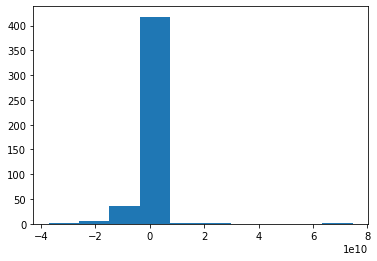

Property Plant Equipment:9


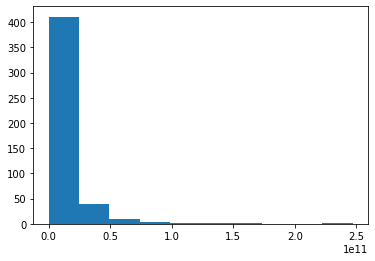

Net Receivables:20


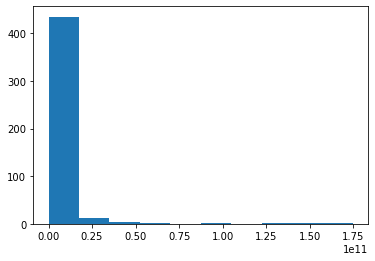

Long Term Debt:30


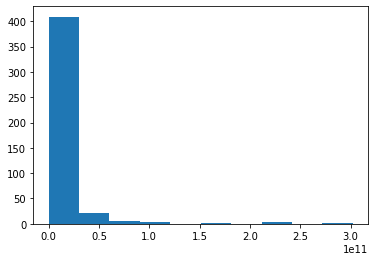

Accounts Payable:6


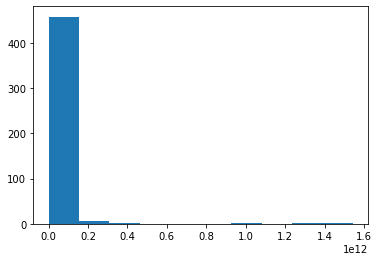

Intangible Assets:67


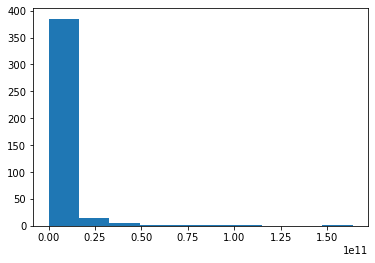

Good Will:53


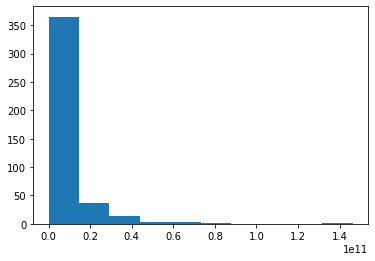

Capital Surplus:73


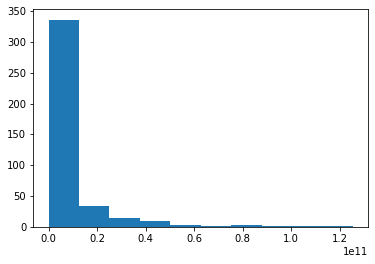

In [60]:
for column in df.columns:
    
    na = df[column].isna().sum()
    
    if na > 0:
    
        print("{}:{}".format(column, na))
        plt.hist(df[column])
        plt.show()
    

Issuance of Stock, Repurchase of Stock, Other Cashflows, Dividens Paid, Other Current Liab, Other Assets, retained earnings, other liabilites, treasury stock, other assets, other stock holder equity, porperty plant, intangible assets, capital surplus mark as 0.

Get rid of common stock

The following columns more than likley have null values due to the values being 0.

In [61]:
zeros = ['Intangible Assets','Repurchase Of Stock', 'Other Cashflows From Investing Activities','Dividends Paid','Change To Account Receivables','Other Cashflows From Financing Activities','Other Current Liab','Other Current Assets','Retained Earnings','Other Liab','Treasury Stock','Other Assets','Other Stockholder Equity','Property Plant Equipment','Accounts Payable', 'Capital Surplus']

In [62]:
for column in zeros:
    
    df[column] = df[column].fillna(0)

In [63]:
for column in df.columns:
    
    na = df[column].isna().sum()
    
    if na > 0:
    
        print("{}:{}".format(column, na))

volatility:6
Investments:94
Net Borrowings:7
Change To Operating Activities:12
Issuance Of Stock:94
Depreciation:1
Capital Expenditures:32
Common Stock:21
Net Receivables:20
Long Term Debt:30
Good Will:53


In [64]:
df = df.drop(columns = 'Common Stock')

In [65]:
df = df.drop(columns = 'Issuance Of Stock')

In [66]:
for column in df.columns:
    
    na = df[column].isna().sum()
    
    if na > 0:
    
        print("{}:{}".format(column, na))

volatility:6
Investments:94
Net Borrowings:7
Change To Operating Activities:12
Depreciation:1
Capital Expenditures:32
Net Receivables:20
Long Term Debt:30
Good Will:53


In [67]:
for column in df.columns:
    
    na = df[column].isna().sum()
    
    if na > 0:
    
        df[column] = df[column].fillna(df[column].median())

<AxesSubplot:>

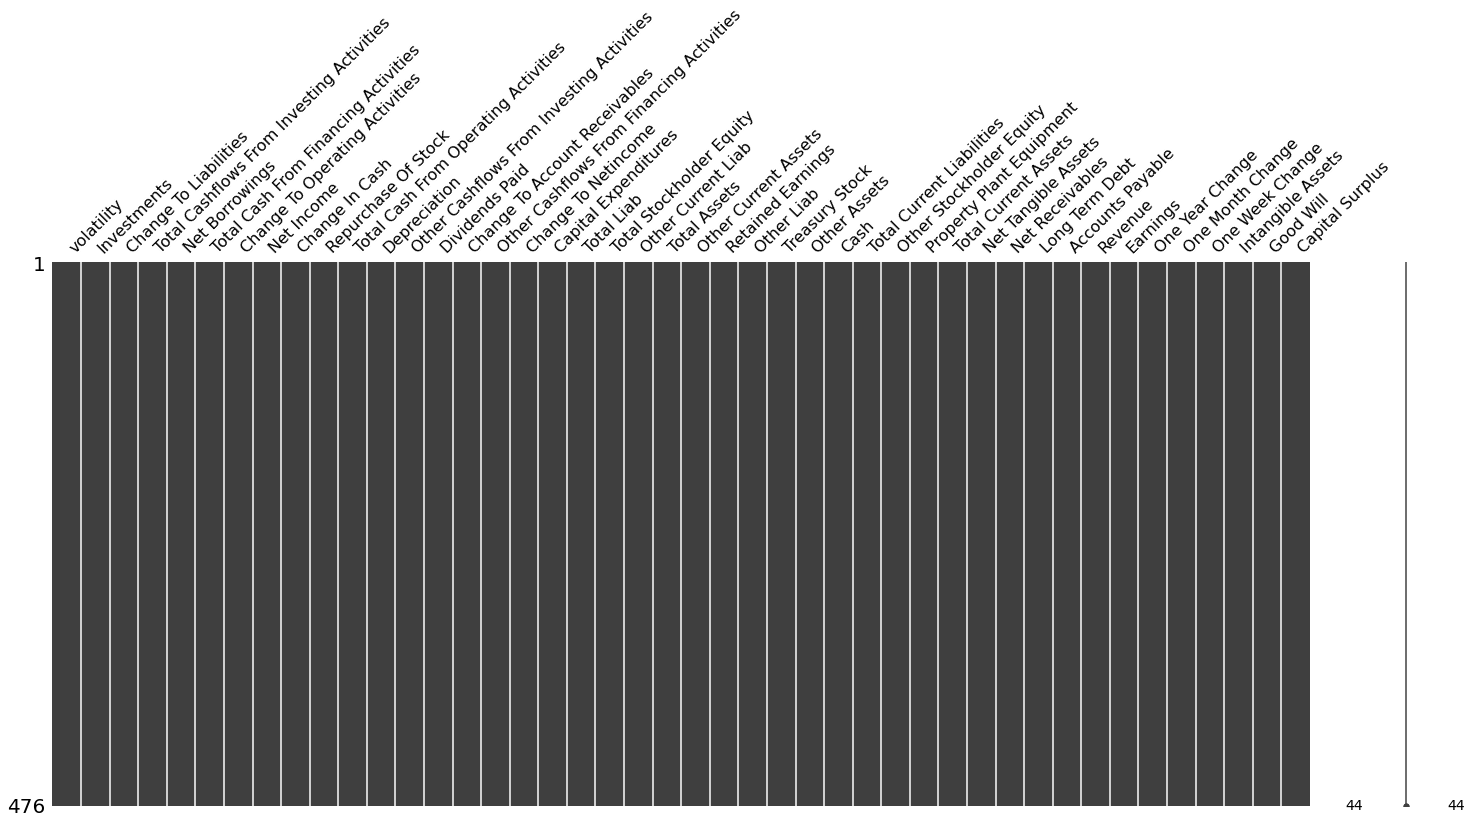

In [68]:
msno.matrix(df)

In [69]:
df

,volatility,Investments,Change To Liabilities,Total Cashflows From Investing Activities,Net Borrowings,Total Cash From Financing Activities,Change To Operating Activities,Net Income,Change In Cash,Repurchase Of Stock,...,Long Term Debt,Accounts Payable,Revenue,Earnings,One Year Change,One Month Change,One Week Change,Intangible Assets,Good Will,Capital Surplus
0,2.369968,3.084500e+10,9.172000e+09,1.606600e+10,4.320000e+08,-8.787600e+10,3.001600e+10,5.953100e+10,5.624000e+09,-7.526500e+10,...,9.373500e+10,5.588800e+10,2.655950e+11,5.953100e+10,0.050251,-0.121304,-0.060047,0.000000e+00,2.923136e+09,0.000000e+00
1,7.524141,5.400000e+08,4.694000e+09,-1.577300e+10,-4.000000e+09,-3.688700e+10,-1.542000e+09,3.924000e+10,-5.900000e+08,-1.954300e+10,...,6.666200e+10,9.382000e+09,1.258430e+11,3.924000e+10,-0.111706,-0.102336,-0.054914,7.750000e+09,4.202600e+10,0.000000e+00
2,2.636179,-1.972000e+09,1.438000e+09,-2.850400e+10,-6.100000e+07,-1.317900e+10,7.890000e+09,3.073600e+10,5.986000e+09,-9.075000e+09,...,3.950000e+09,4.378000e+09,1.368190e+11,3.073600e+10,-0.203978,-0.130209,-0.062179,2.220000e+09,1.788800e+10,0.000000e+00
3,2.542476,-1.972000e+09,1.438000e+09,-2.850400e+10,-6.100000e+07,-1.317900e+10,7.890000e+09,3.073600e+10,5.986000e+09,-9.075000e+09,...,3.950000e+09,4.378000e+09,1.368190e+11,3.073600e+10,-0.203751,-0.128869,-0.063036,2.220000e+09,1.788800e+10,0.000000e+00
4,11.836587,1.140000e+09,4.414000e+09,-1.236900e+10,-7.686000e+09,-7.686000e+09,4.720000e+08,1.007300e+10,1.031700e+10,0.000000e+00,...,2.349500e+10,3.819200e+10,2.328870e+11,1.007300e+10,-0.332468,-0.129432,-0.075104,4.110000e+09,1.454800e+10,2.679100e+10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
471,3.733131,-6.959500e+06,2.900000e+07,-6.090000e+08,7.000000e+06,-8.720000e+08,1.280000e+08,6.440000e+08,-1.020000e+08,-2.110000e+08,...,5.739000e+09,7.110000e+08,1.323700e+10,6.440000e+08,-0.512504,-0.289205,-0.110921,4.110000e+08,1.348000e+09,7.710000e+08
472,0.672664,3.723600e+07,2.650000e+06,-1.922470e+08,-5.762000e+07,-2.413090e+08,2.422000e+07,2.419070e+08,8.313200e+07,-9.580000e+05,...,3.157685e+09,1.748220e+08,9.120380e+08,2.419070e+08,-0.429384,-0.140825,-0.076647,1.528500e+07,2.923136e+09,3.004442e+09
473,1.099194,-2.870000e+07,2.100000e+07,-6.343000e+08,8.262000e+08,-6.800000e+06,-2.950000e+07,3.896000e+08,-5.230000e+07,-7.086000e+08,...,1.809000e+09,4.590000e+08,5.485100e+09,3.896000e+08,-0.372632,-0.140401,-0.070104,1.246800e+09,2.080300e+09,2.766000e+09
474,0.420448,-6.959500e+06,1.240000e+08,-3.078000e+09,-1.661000e+09,-4.023000e+09,-1.930000e+08,-1.733000e+09,-6.900000e+07,-1.000000e+09,...,3.521300e+10,1.933000e+09,2.258000e+10,-1.733000e+09,-0.236360,-0.204833,-0.093782,1.077900e+10,2.803100e+10,2.285200e+10


In [70]:
for column in df.columns:
    
    if column != 'Revenue':
    
        df[column + '/Revenue'] = df[column]/df['Revenue']

In [71]:
df = df.drop(columns= ['One Year Change/Revenue','One Month Change/Revenue','One Week Change/Revenue'])

In [72]:
df

,volatility,Investments,Change To Liabilities,Total Cashflows From Investing Activities,Net Borrowings,Total Cash From Financing Activities,Change To Operating Activities,Net Income,Change In Cash,Repurchase Of Stock,...,Property Plant Equipment/Revenue,Total Current Assets/Revenue,Net Tangible Assets/Revenue,Net Receivables/Revenue,Long Term Debt/Revenue,Accounts Payable/Revenue,Earnings/Revenue,Intangible Assets/Revenue,Good Will/Revenue,Capital Surplus/Revenue
0,2.369968,3.084500e+10,9.172000e+09,1.606600e+10,4.320000e+08,-8.787600e+10,3.001600e+10,5.953100e+10,5.624000e+09,-7.526500e+10,...,0.155515,0.494509,0.403423,0.184473,0.352925,0.210426,0.224142,0.000000,0.011006,0.000000
1,7.524141,5.400000e+08,4.694000e+09,-1.577300e+10,-4.000000e+09,-3.688700e+10,-1.542000e+09,3.924000e+10,-5.900000e+08,-1.954300e+10,...,0.348498,1.395008,0.417616,0.234610,0.529724,0.074553,0.311817,0.061585,0.333956,0.000000
2,2.636179,-1.972000e+09,1.438000e+09,-2.850400e+10,-6.100000e+07,-1.317900e+10,7.890000e+09,3.073600e+10,5.986000e+09,-9.075000e+09,...,0.436482,0.991646,1.151302,0.154898,0.028870,0.031998,0.224647,0.016226,0.130742,0.000000
3,2.542476,-1.972000e+09,1.438000e+09,-2.850400e+10,-6.100000e+07,-1.317900e+10,7.890000e+09,3.073600e+10,5.986000e+09,-9.075000e+09,...,0.436482,0.991646,1.151302,0.154898,0.028870,0.031998,0.224647,0.016226,0.130742,0.000000
4,11.836587,1.140000e+09,4.414000e+09,-1.236900e+10,-7.686000e+09,-7.686000e+09,4.720000e+08,1.007300e+10,1.031700e+10,0.000000e+00,...,0.265352,0.322478,0.106880,0.069815,0.100886,0.163994,0.043253,0.017648,0.062468,0.115039
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
471,3.733131,-6.959500e+06,2.900000e+07,-6.090000e+08,7.000000e+06,-8.720000e+08,1.280000e+08,6.440000e+08,-1.020000e+08,-2.110000e+08,...,0.212888,0.246279,-0.198534,0.027725,0.433557,0.053713,0.048652,0.031049,0.101836,0.058246
472,0.672664,3.723600e+07,2.650000e+06,-1.922470e+08,-5.762000e+07,-2.413090e+08,2.422000e+07,2.419070e+08,8.313200e+07,-9.580000e+05,...,6.297712,0.500793,2.379955,0.155955,3.462230,0.191683,0.265238,0.016759,3.205059,3.294207
473,1.099194,-2.870000e+07,2.100000e+07,-6.343000e+08,8.262000e+08,-6.800000e+06,-2.950000e+07,3.896000e+08,-5.230000e+07,-7.086000e+08,...,0.148293,0.307396,-0.209458,0.104228,0.329803,0.083681,0.071029,0.227307,0.379264,0.504275
474,0.420448,-6.959500e+06,1.240000e+08,-3.078000e+09,-1.661000e+09,-4.023000e+09,-1.930000e+08,-1.733000e+09,-6.900000e+07,-1.000000e+09,...,1.169531,0.169176,-0.840655,0.112135,1.559477,0.085607,-0.076749,0.477369,1.241408,1.012046


In [73]:
maxs = []
mins = []

for column in df.columns:
    
    maxs.append(df[column].idxmax())
    mins.append(df[column].idxmin())
    
    
both = maxs + mins


max_mins = pd.DataFrame({'col1':both})
    

In [74]:
max_mins['col1'].value_counts()

11     16
124    15
0      11
52      7
407     7
       ..
1       1
35      1
140     1
453     1
360     1
Name: col1, Length: 69, dtype: int64

In [75]:
max_mins['col1'].value_counts().index

Int64Index([ 11, 124,   0,  52, 407,  68,  63,  90,  48, 447,  36, 158,   8,
            452,  19,  14, 137, 359, 457, 460,  60,  78, 243, 282, 313,   4,
             24, 265,   2, 335, 107, 276, 419, 385, 198, 370, 147, 379,  65,
            269, 228, 401, 404, 270,  46, 110, 207, 136,  30, 197,  10,  13,
            416,  69, 381, 314, 324, 106,  47, 200, 262, 301, 141, 230,   1,
             35, 140, 453, 360],
           dtype='int64')

In [76]:
for value, index in zip(max_mins['col1'].value_counts(),max_mins['col1'].value_counts().index):
    
    if value > 3:
        
        df.drop(index)

# Some EDA

volatility


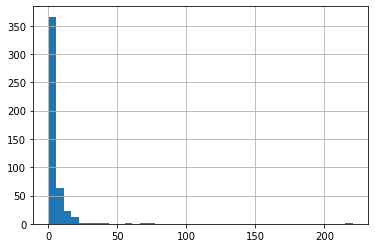

Investments


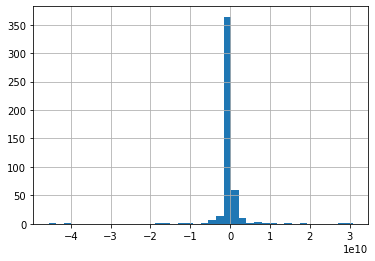

Change To Liabilities


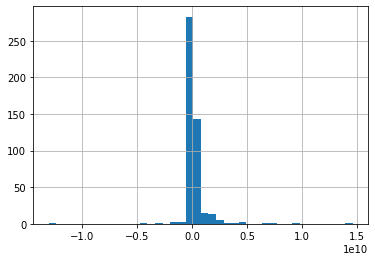

Total Cashflows From Investing Activities


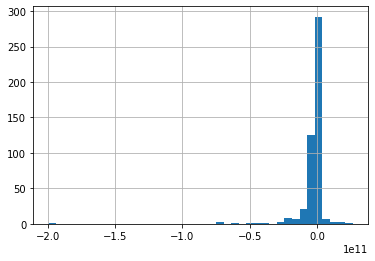

Net Borrowings


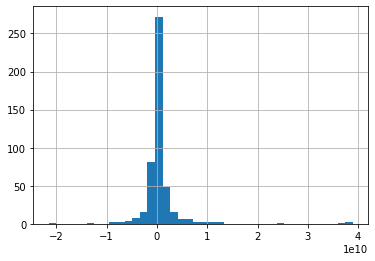

Total Cash From Financing Activities


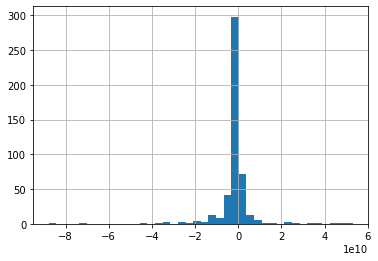

Change To Operating Activities


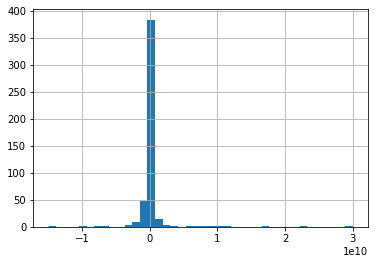

Net Income


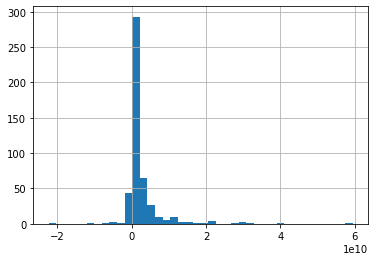

Change In Cash


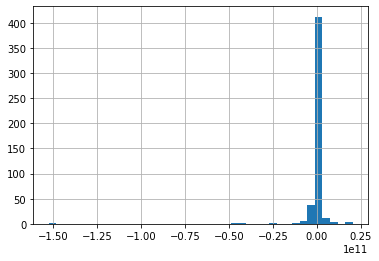

Repurchase Of Stock


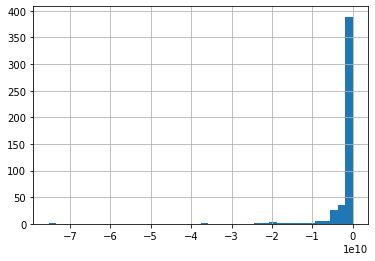

Total Cash From Operating Activities


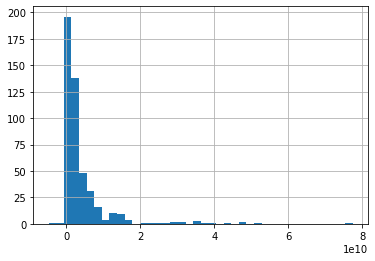

Depreciation


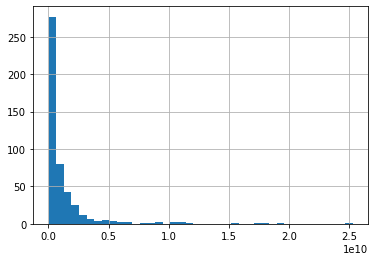

Other Cashflows From Investing Activities


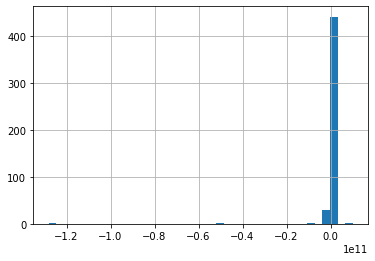

Dividends Paid


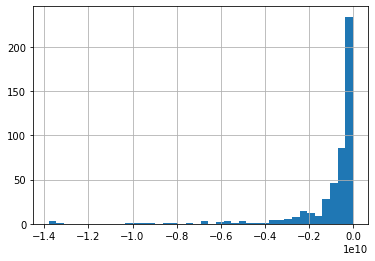

Change To Account Receivables


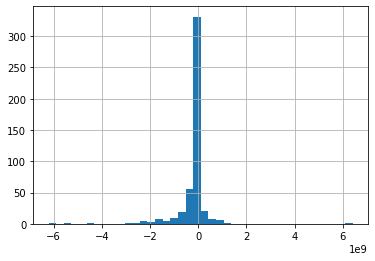

Other Cashflows From Financing Activities


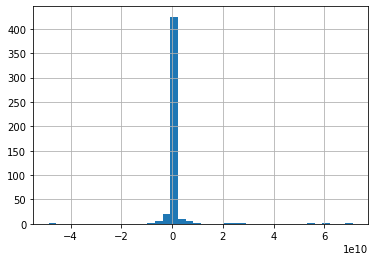

Change To Netincome


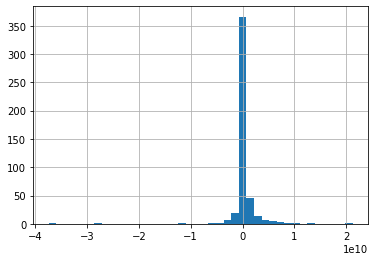

Capital Expenditures


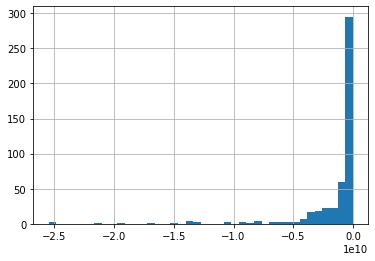

Total Liab


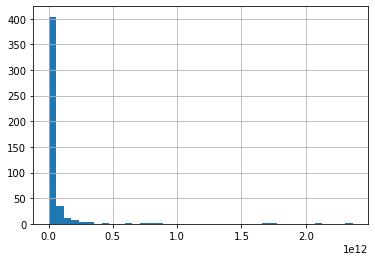

Total Stockholder Equity


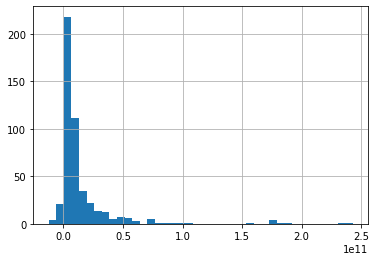

Other Current Liab


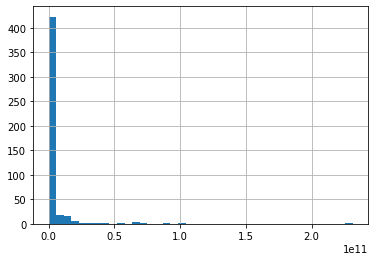

Total Assets


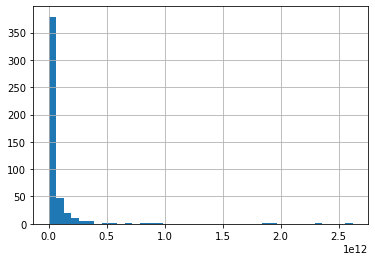

Other Current Assets


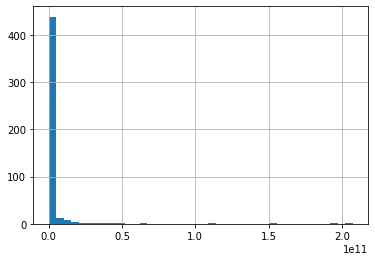

Retained Earnings


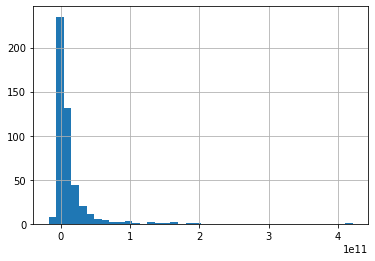

Other Liab


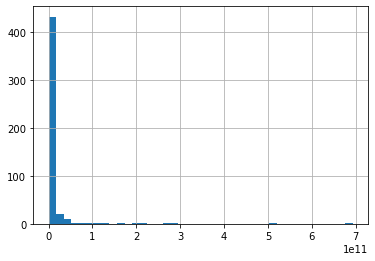

Treasury Stock


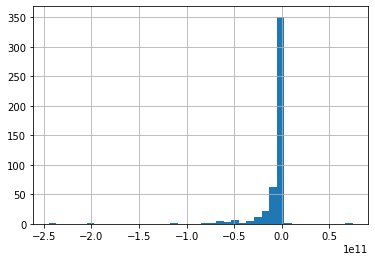

Other Assets


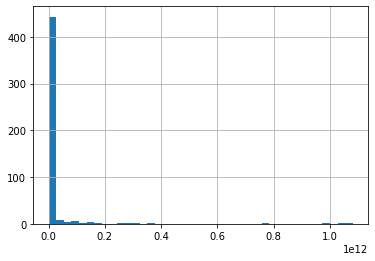

Cash


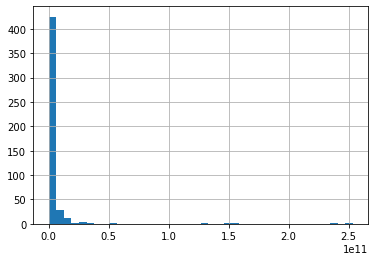

Total Current Liabilities


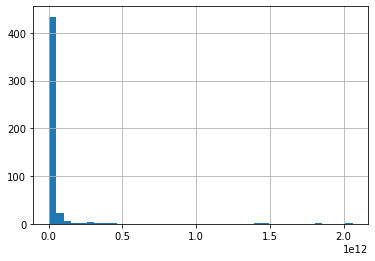

Other Stockholder Equity


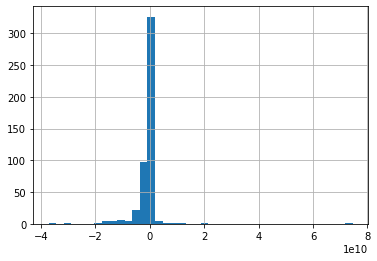

Property Plant Equipment


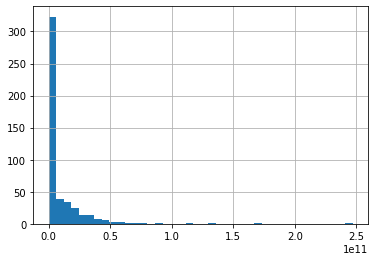

Total Current Assets


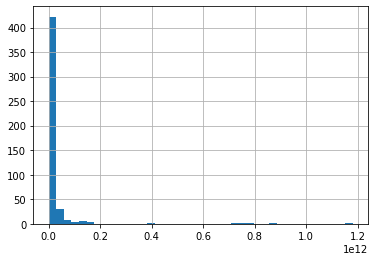

Net Tangible Assets


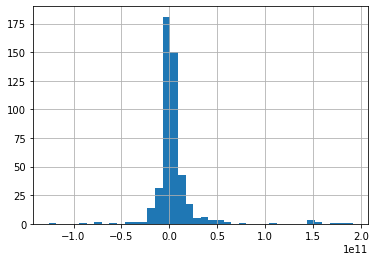

Net Receivables


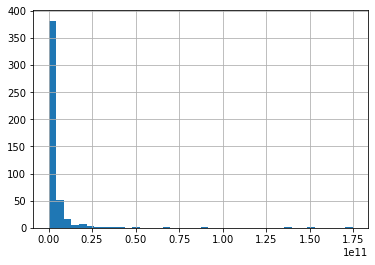

Long Term Debt


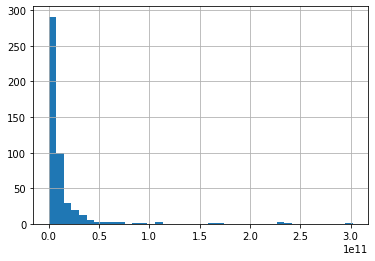

Accounts Payable


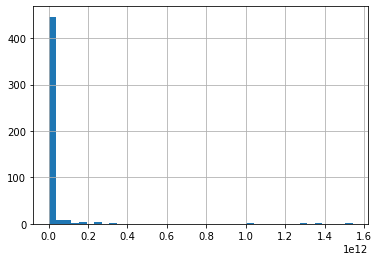

Revenue


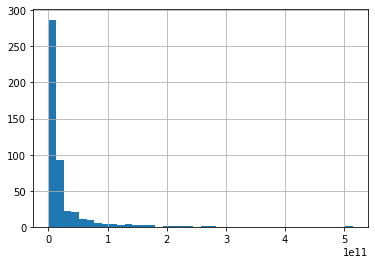

Earnings


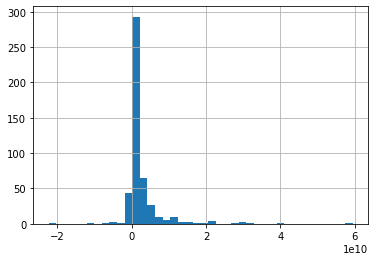

One Year Change


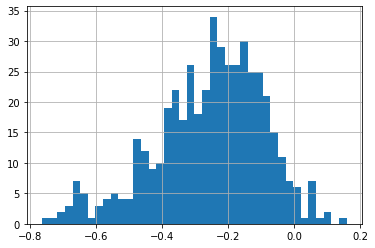

One Month Change


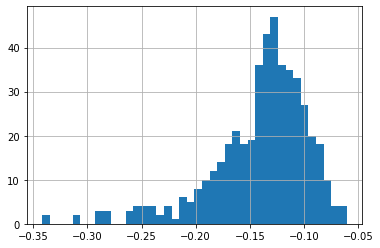

One Week Change


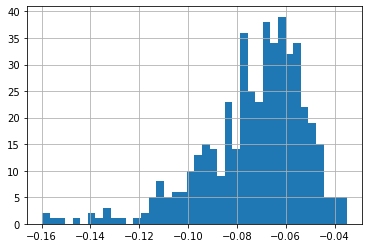

Intangible Assets


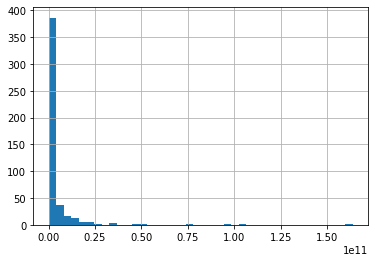

Good Will


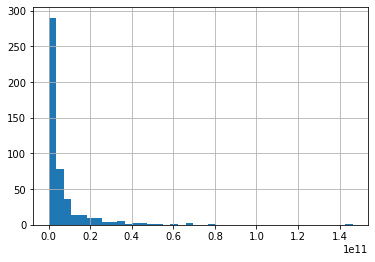

Capital Surplus


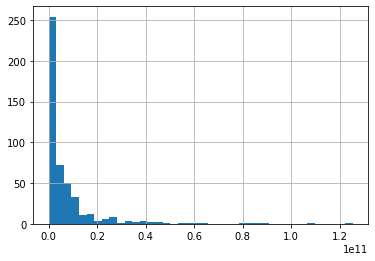

volatility/Revenue


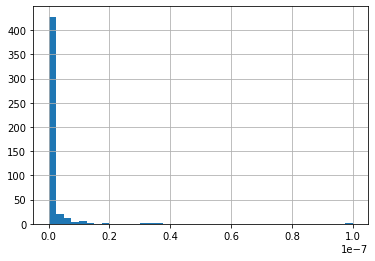

Investments/Revenue


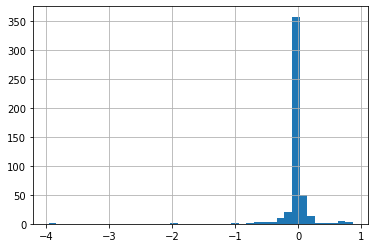

Change To Liabilities/Revenue


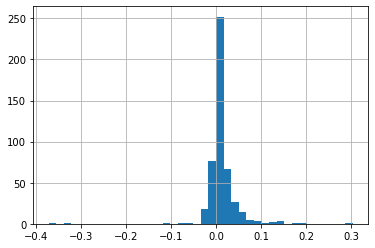

Total Cashflows From Investing Activities/Revenue


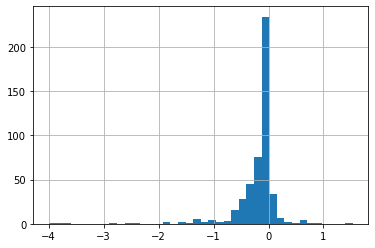

Net Borrowings/Revenue


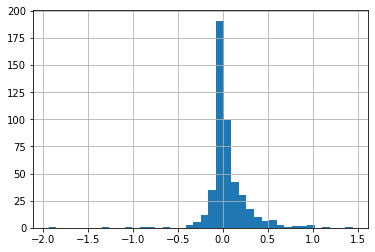

Total Cash From Financing Activities/Revenue


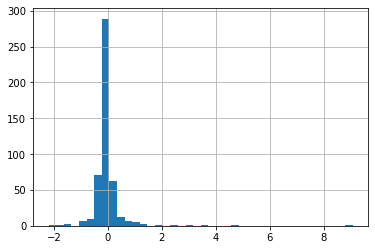

Change To Operating Activities/Revenue


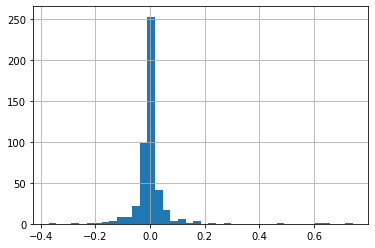

Net Income/Revenue


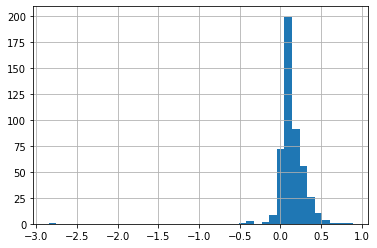

Change In Cash/Revenue


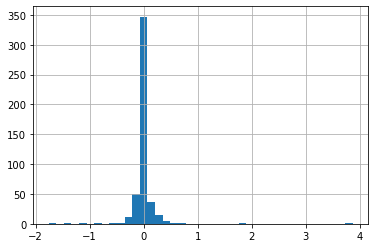

Repurchase Of Stock/Revenue


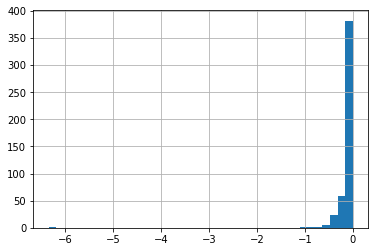

Total Cash From Operating Activities/Revenue


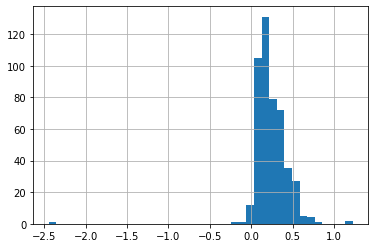

Depreciation/Revenue


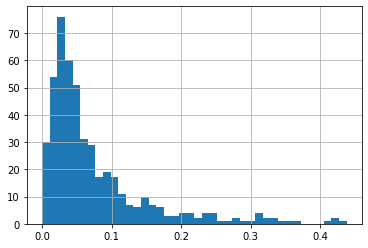

Other Cashflows From Investing Activities/Revenue


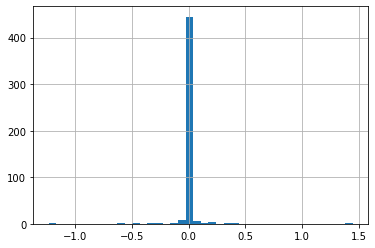

Dividends Paid/Revenue


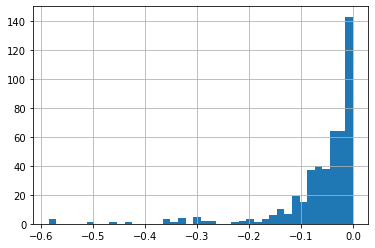

Change To Account Receivables/Revenue


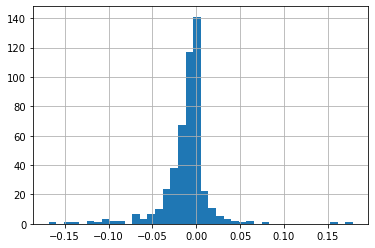

Other Cashflows From Financing Activities/Revenue


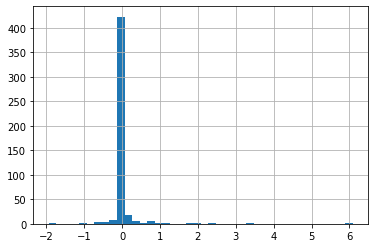

Change To Netincome/Revenue


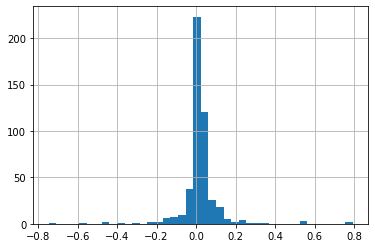

Capital Expenditures/Revenue


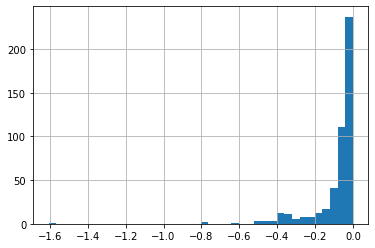

Total Liab/Revenue


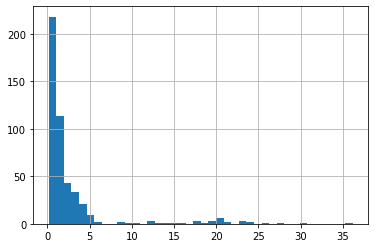

Total Stockholder Equity/Revenue


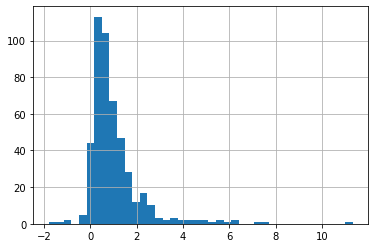

Other Current Liab/Revenue


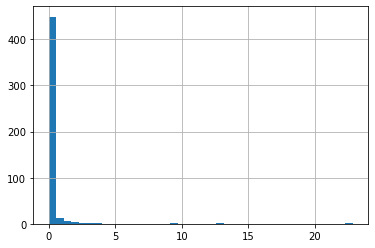

Total Assets/Revenue


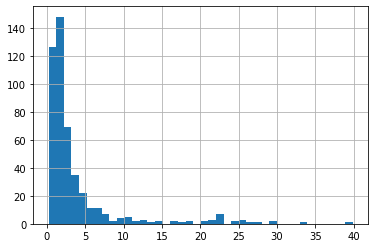

Other Current Assets/Revenue


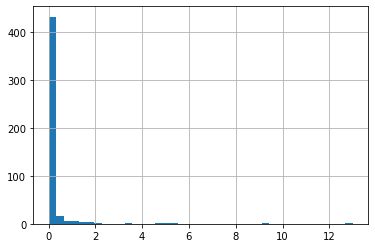

Retained Earnings/Revenue


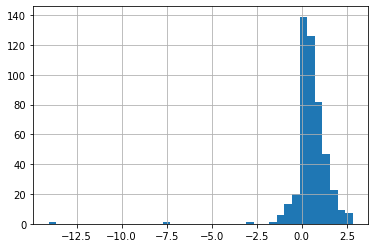

Other Liab/Revenue


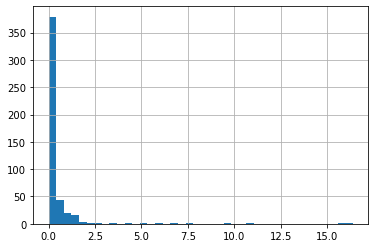

Treasury Stock/Revenue


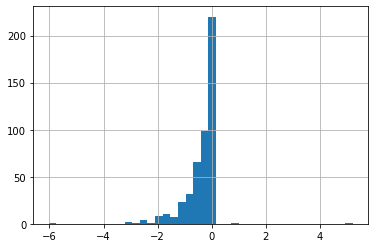

Other Assets/Revenue


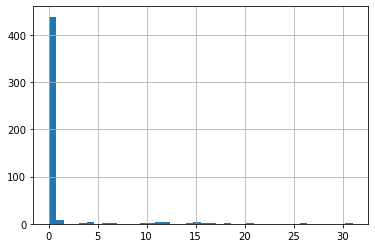

Cash/Revenue


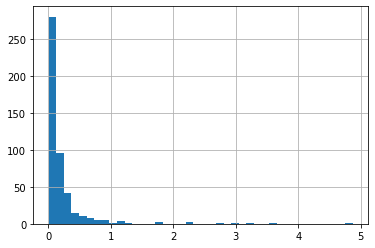

Total Current Liabilities/Revenue


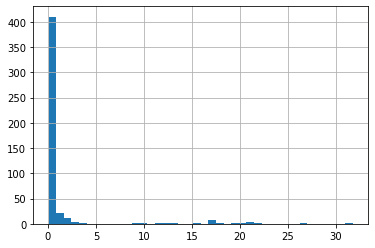

Other Stockholder Equity/Revenue


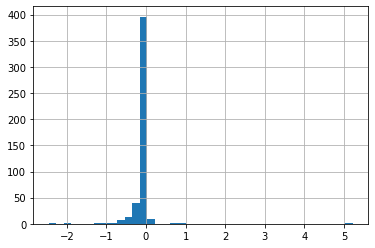

Property Plant Equipment/Revenue


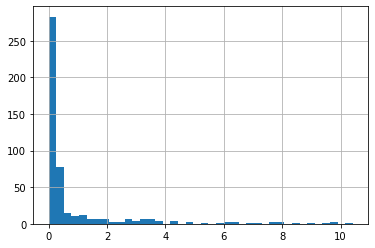

Total Current Assets/Revenue


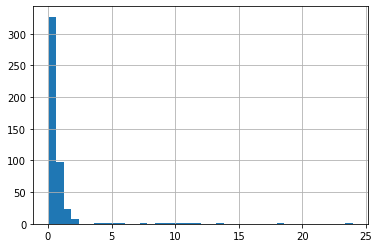

Net Tangible Assets/Revenue


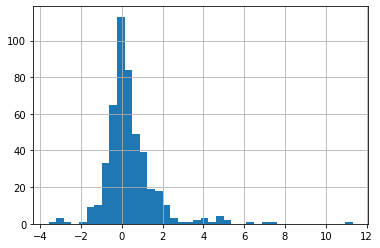

Net Receivables/Revenue


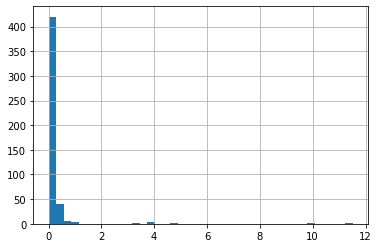

Long Term Debt/Revenue


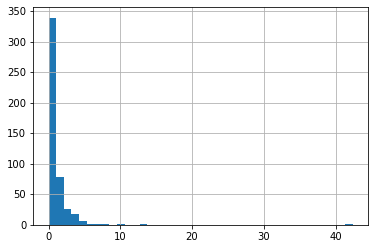

Accounts Payable/Revenue


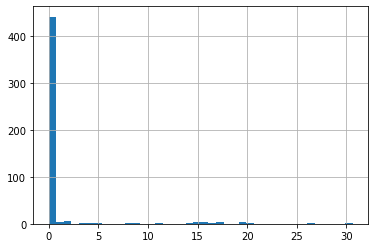

Earnings/Revenue


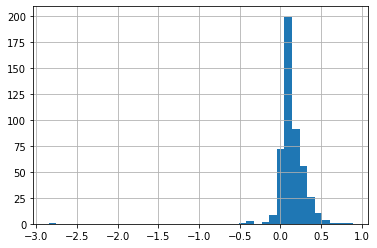

Intangible Assets/Revenue


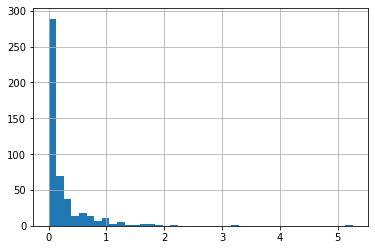

Good Will/Revenue


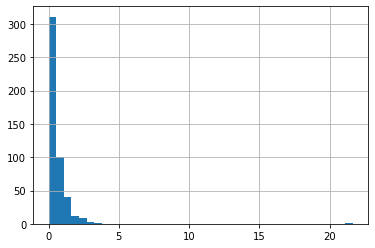

Capital Surplus/Revenue


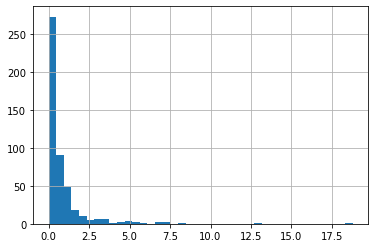

In [77]:
for column in df.columns:
    
    df[column].hist(bins=40)
    print(column)
    plt.show()

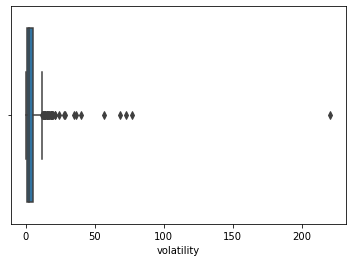

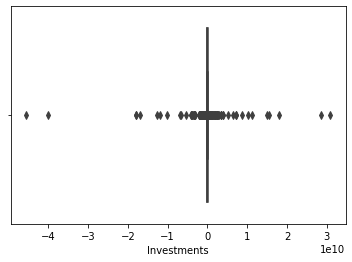

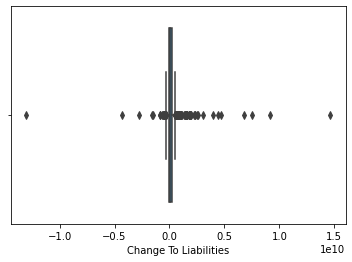

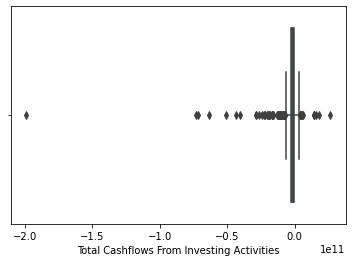

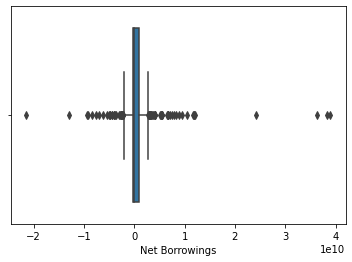

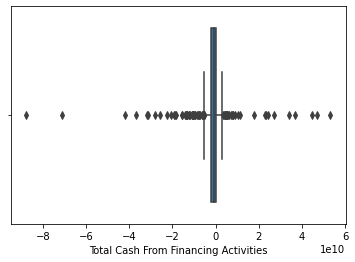

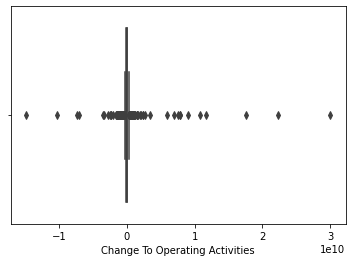

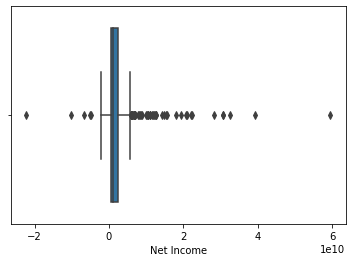

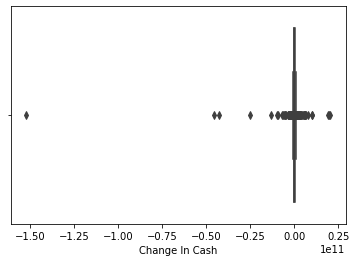

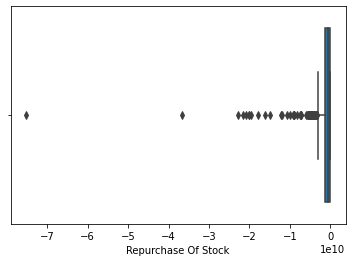

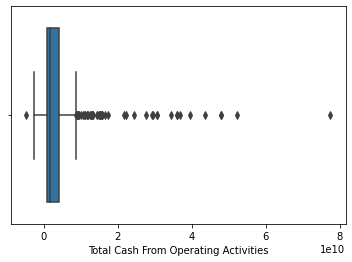

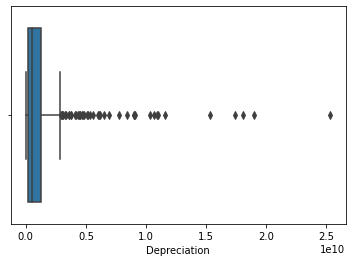

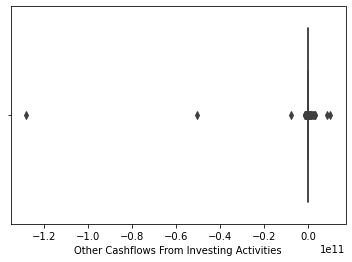

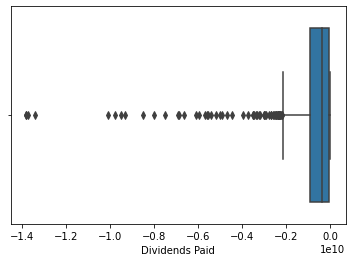

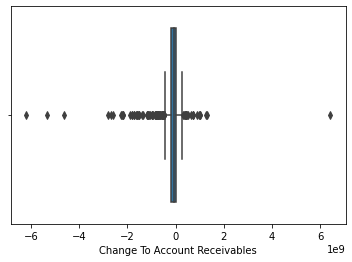

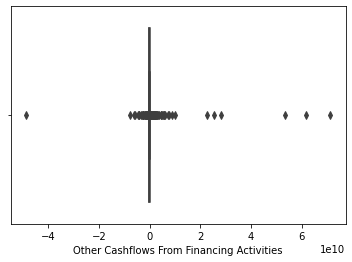

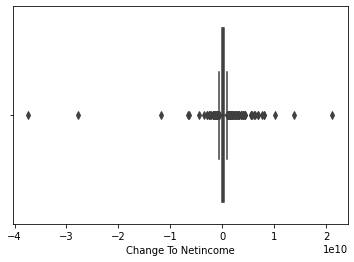

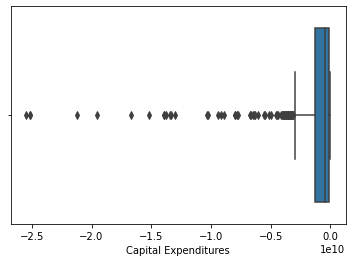

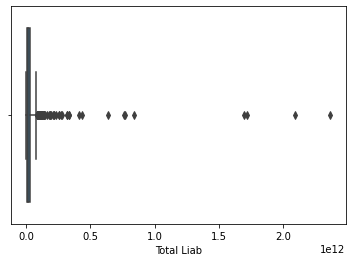

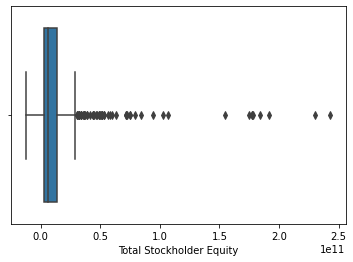

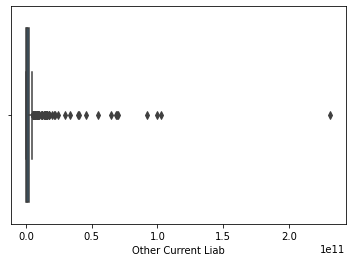

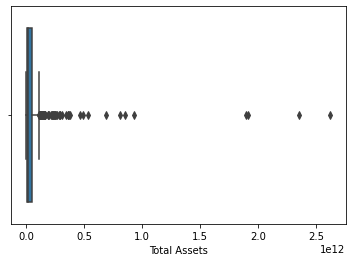

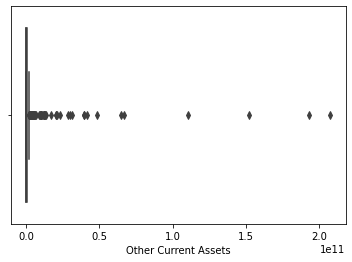

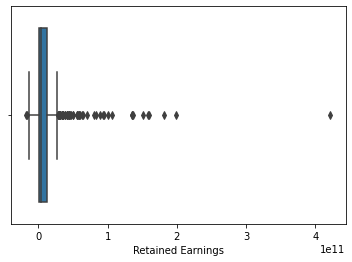

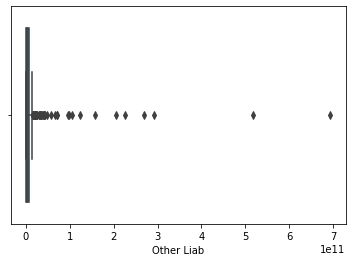

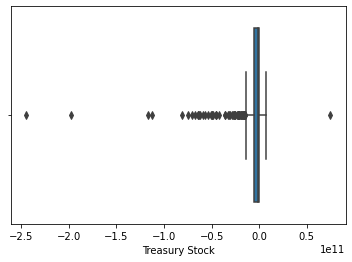

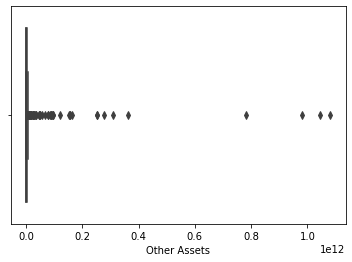

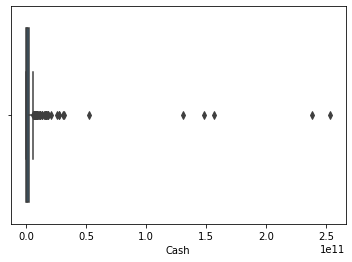

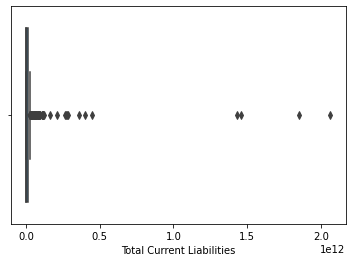

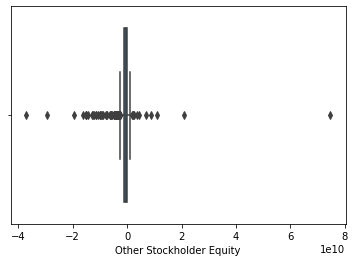

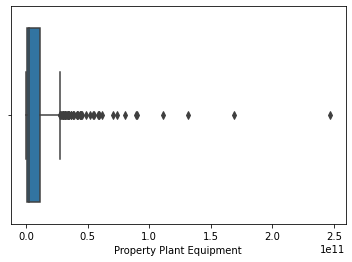

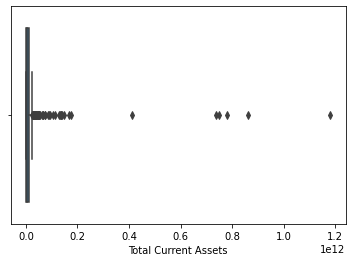

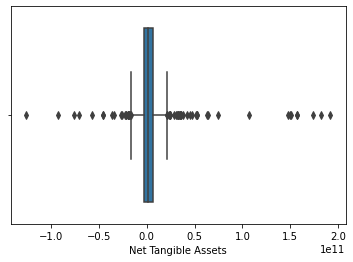

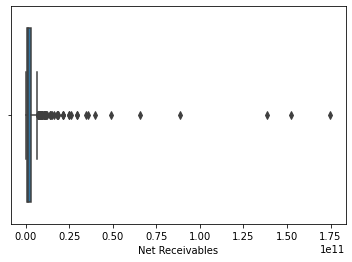

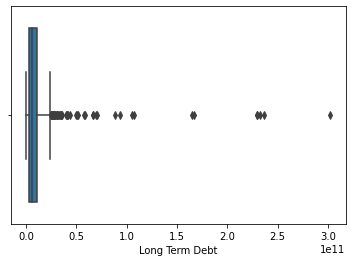

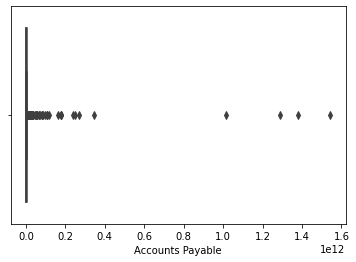

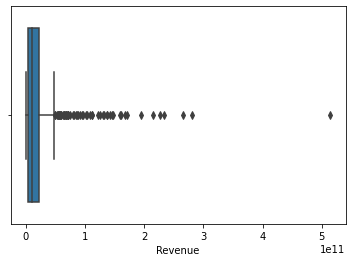

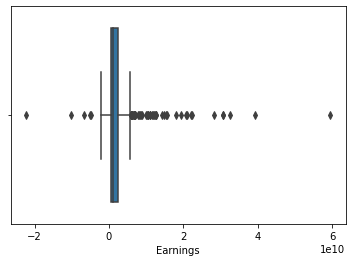

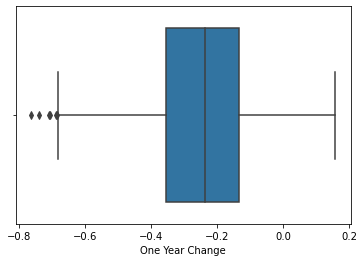

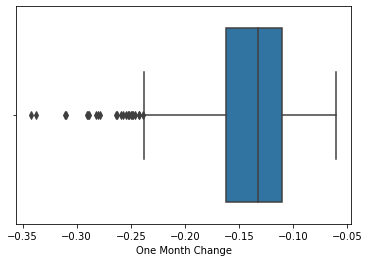

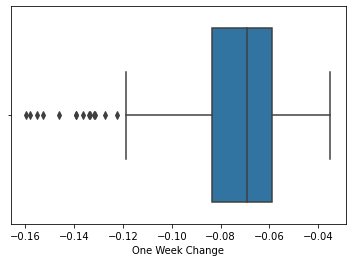

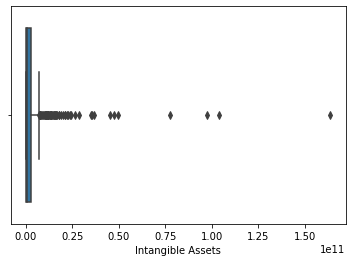

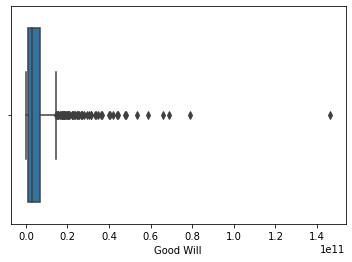

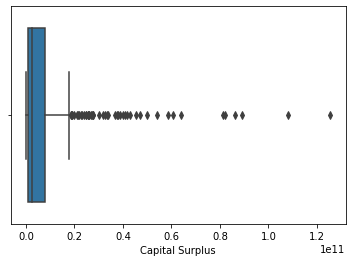

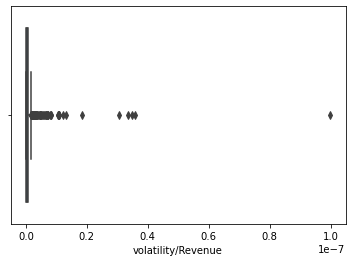

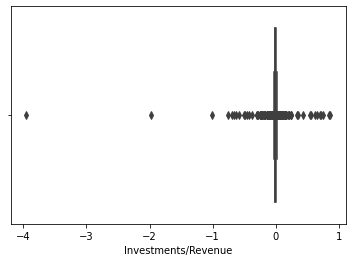

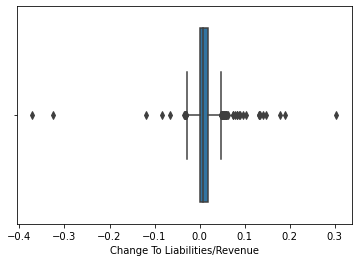

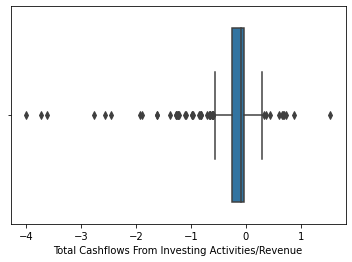

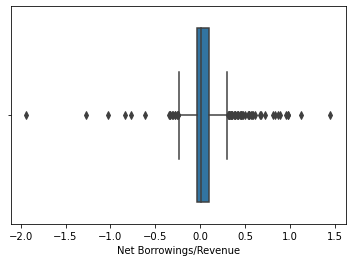

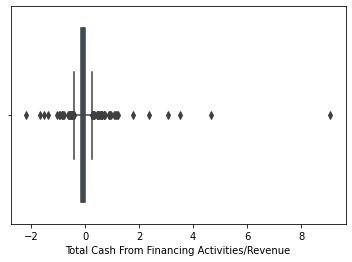

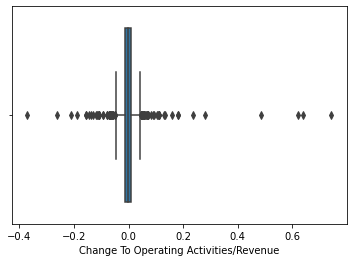

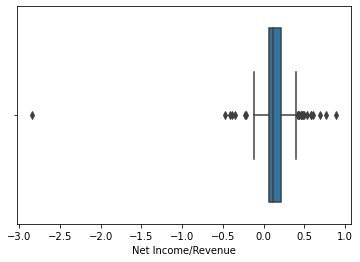

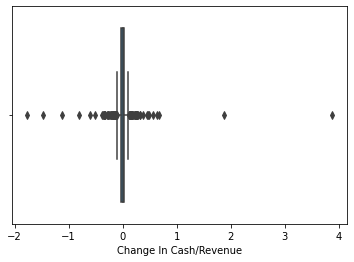

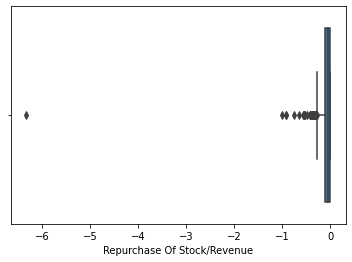

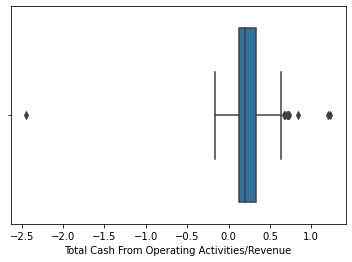

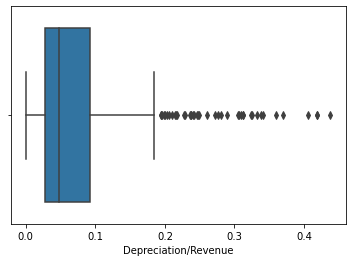

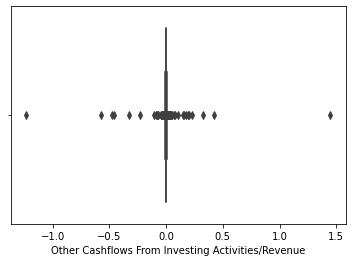

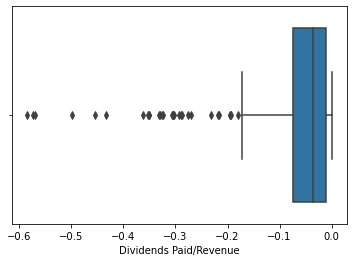

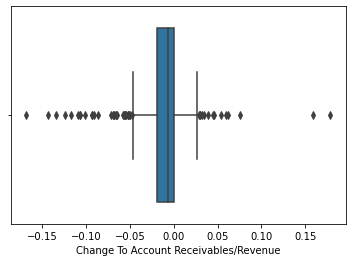

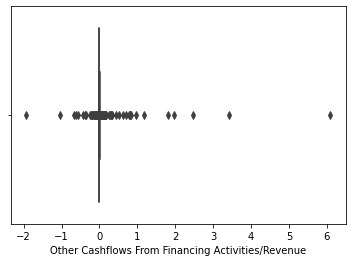

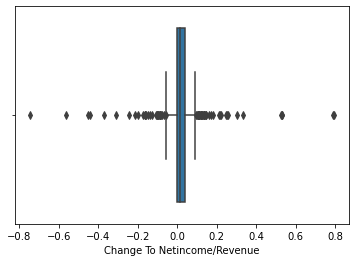

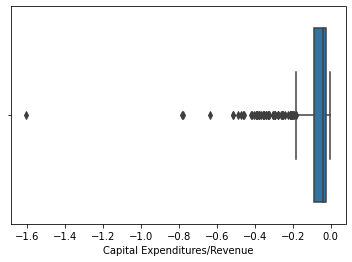

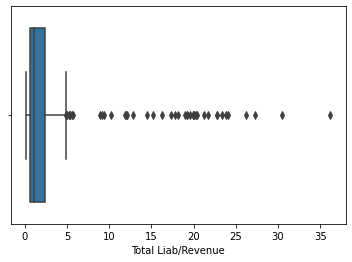

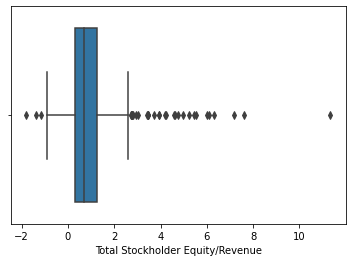

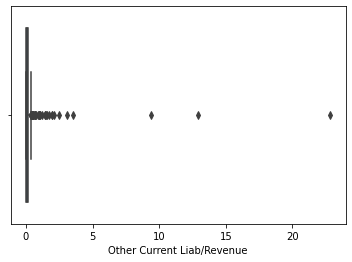

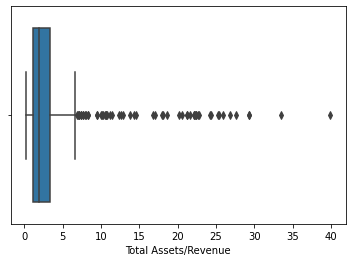

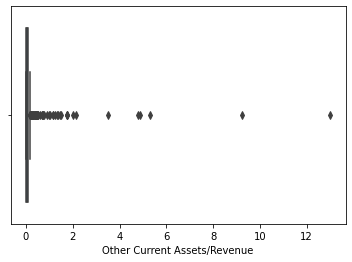

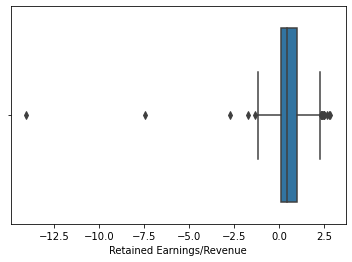

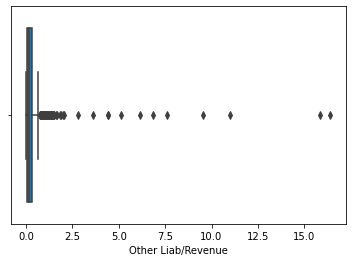

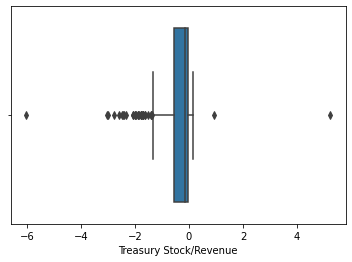

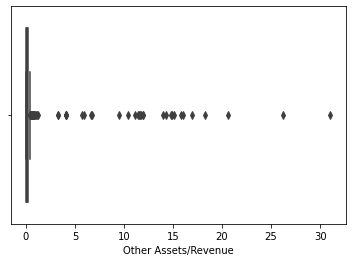

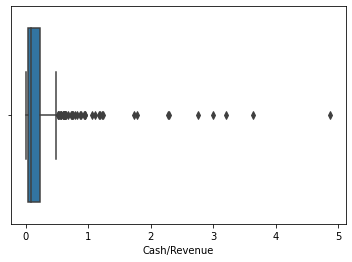

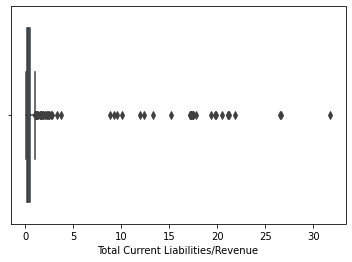

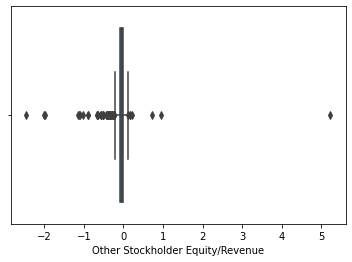

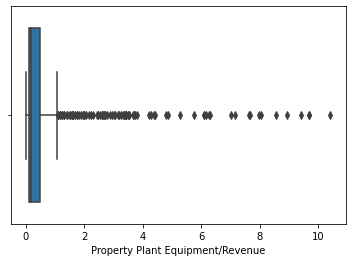

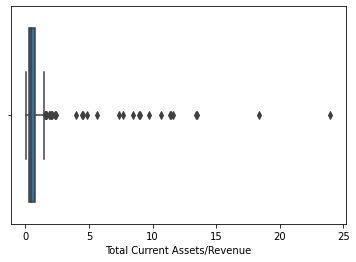

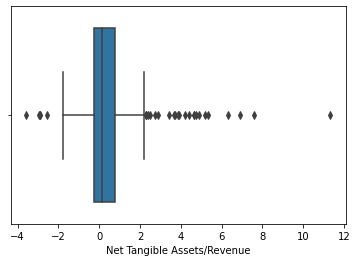

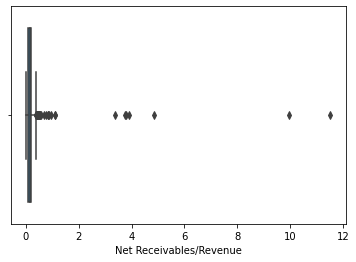

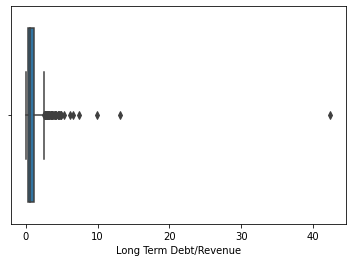

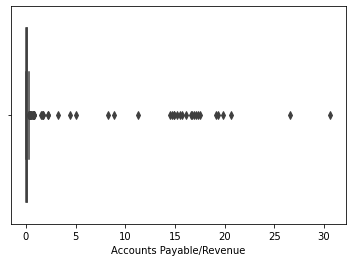

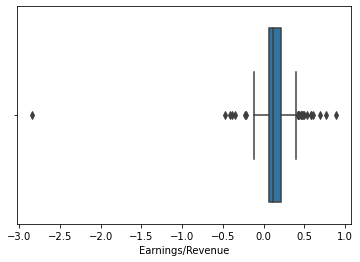

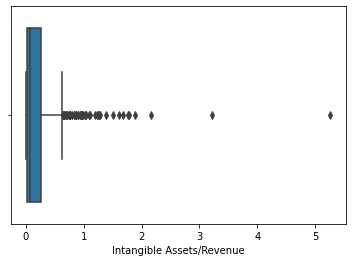

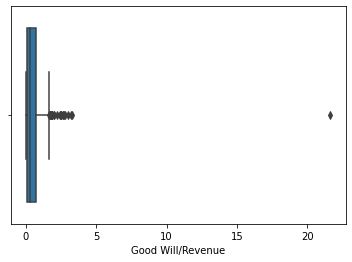

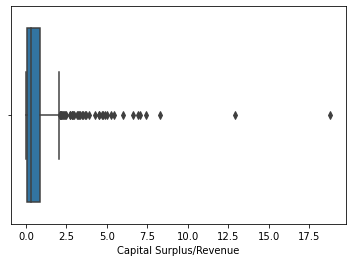

In [78]:
for column in df.columns:
        
    sns.boxplot(x=df[column])
    plt.show()

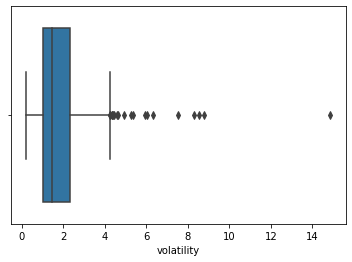

C:\Users\hunte\anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


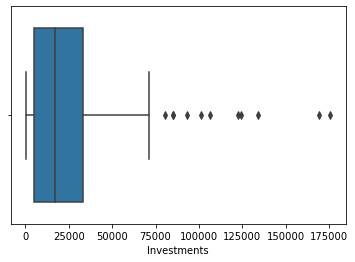

C:\Users\hunte\anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


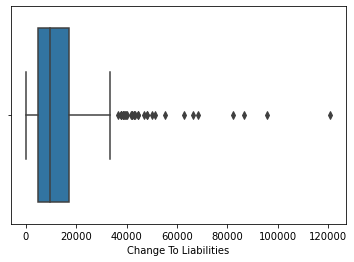

C:\Users\hunte\anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


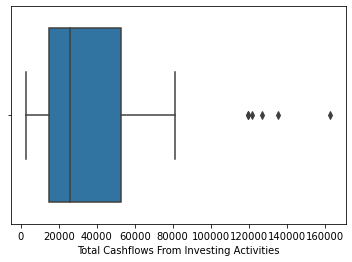

C:\Users\hunte\anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


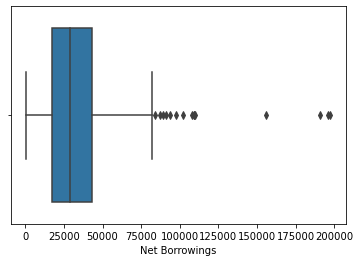

C:\Users\hunte\anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


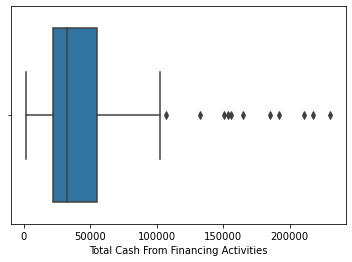

C:\Users\hunte\anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


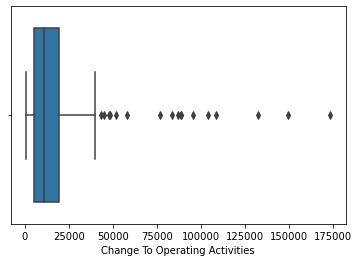

C:\Users\hunte\anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


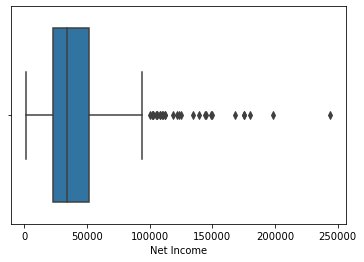

C:\Users\hunte\anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


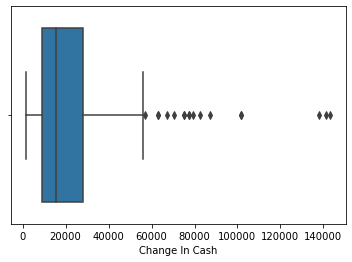

C:\Users\hunte\anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


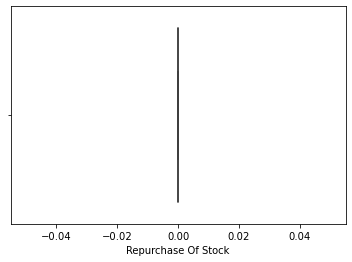

C:\Users\hunte\anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


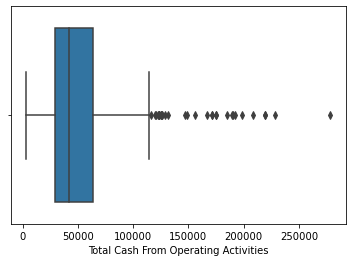

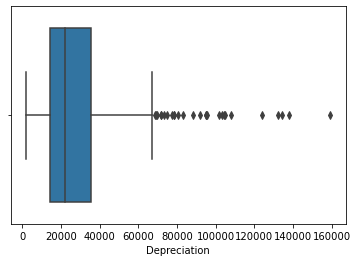

C:\Users\hunte\anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


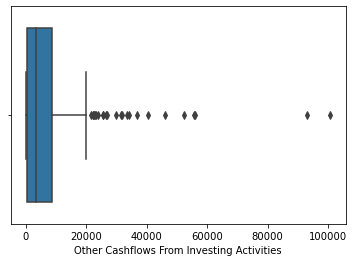

C:\Users\hunte\anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


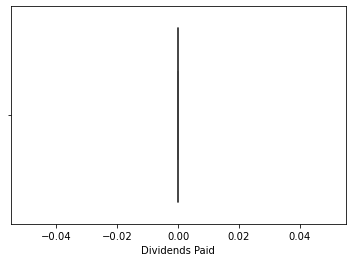

C:\Users\hunte\anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


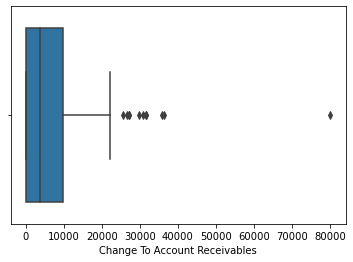

C:\Users\hunte\anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


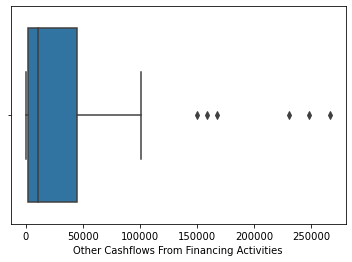

C:\Users\hunte\anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


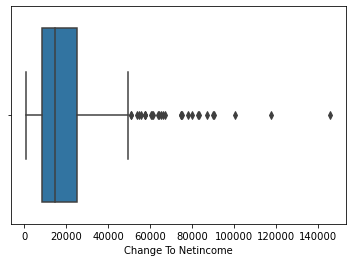

C:\Users\hunte\anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


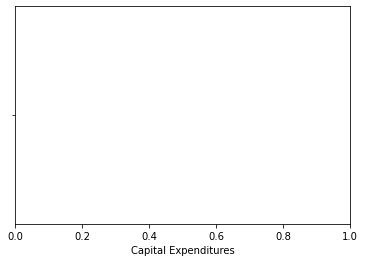

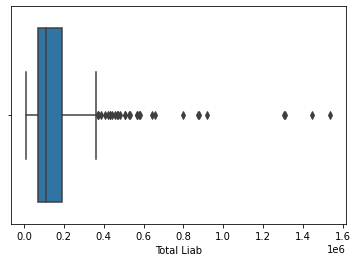

C:\Users\hunte\anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


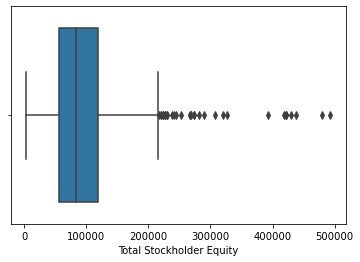

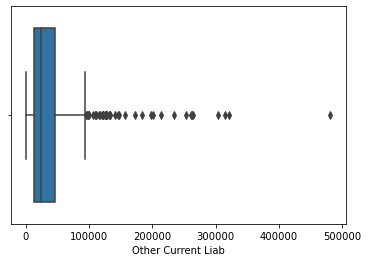

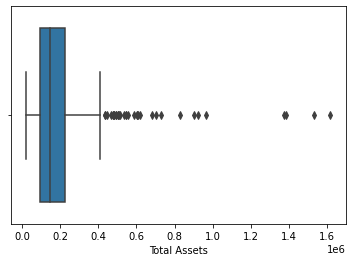

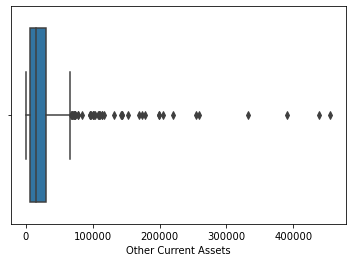

C:\Users\hunte\anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


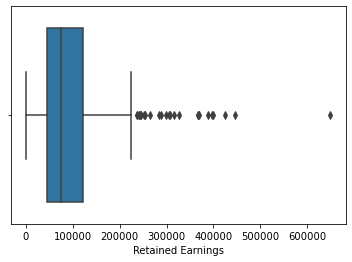

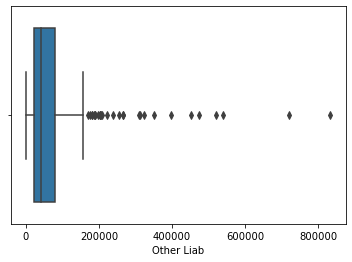

C:\Users\hunte\anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


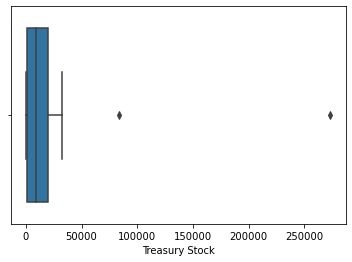

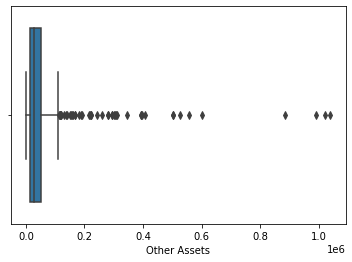

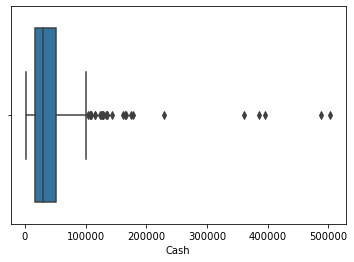

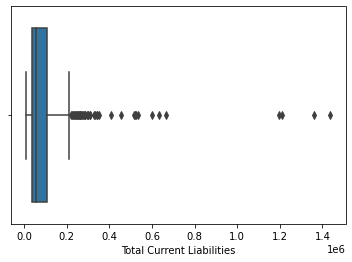

C:\Users\hunte\anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


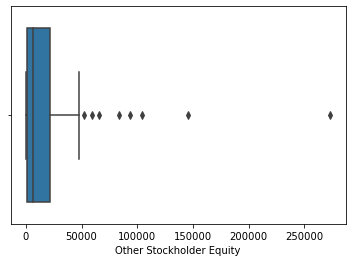

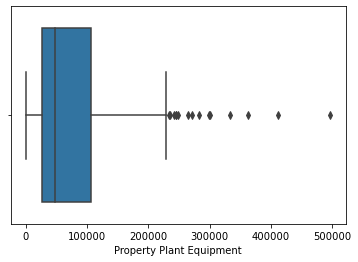

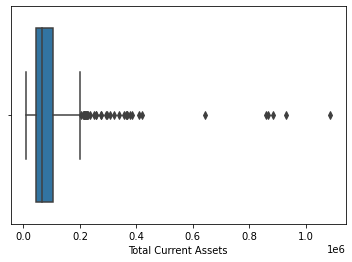

C:\Users\hunte\anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


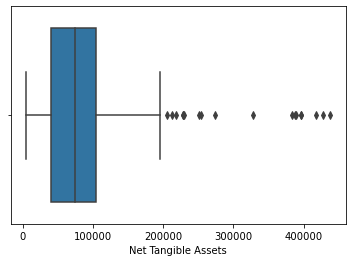

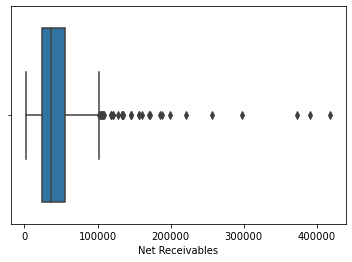

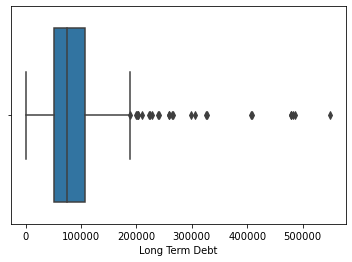

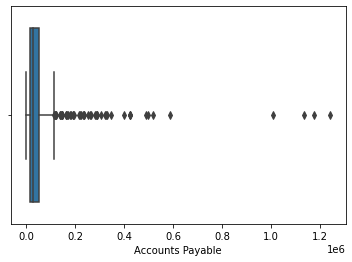

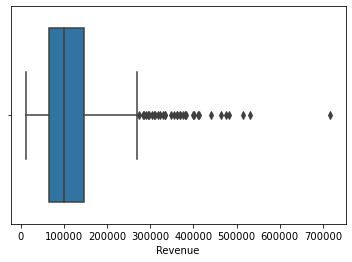

C:\Users\hunte\anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


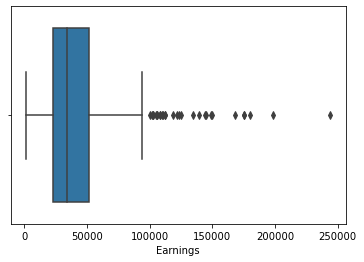

C:\Users\hunte\anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


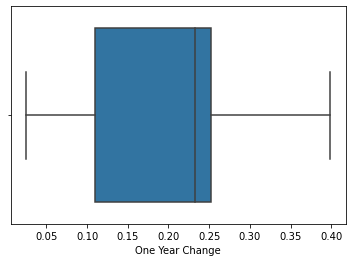

C:\Users\hunte\anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


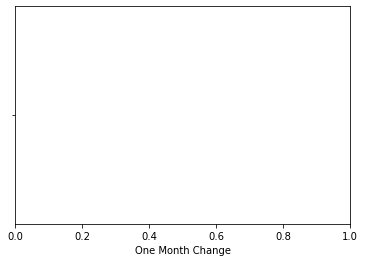

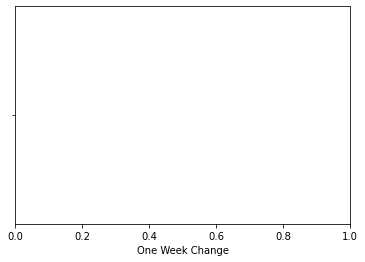

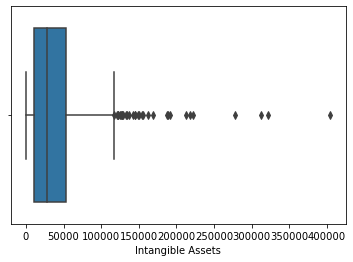

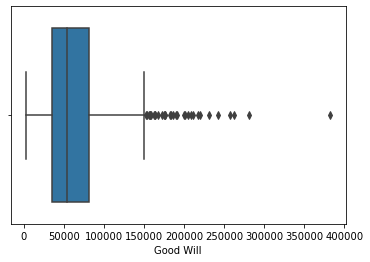

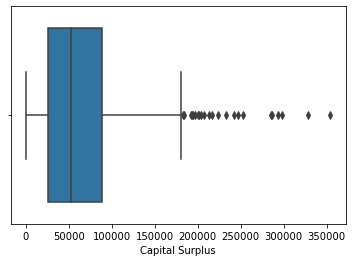

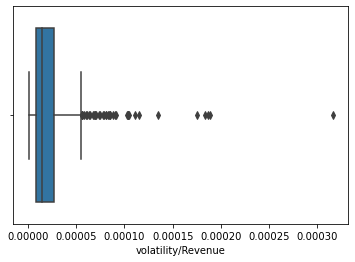

C:\Users\hunte\anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


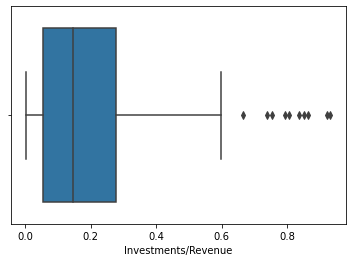

C:\Users\hunte\anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


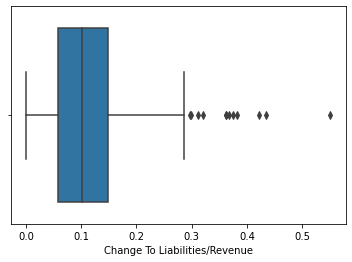

C:\Users\hunte\anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


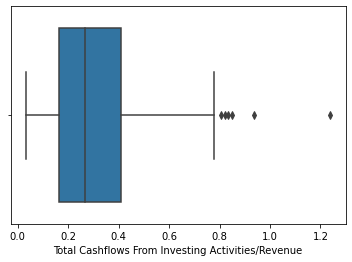

C:\Users\hunte\anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


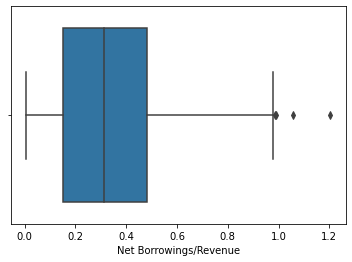

C:\Users\hunte\anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


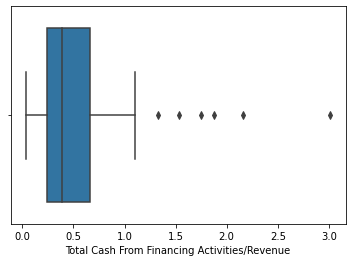

C:\Users\hunte\anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


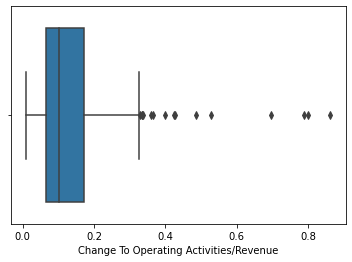

C:\Users\hunte\anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


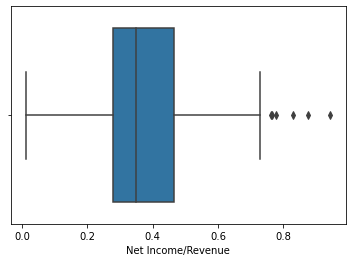

C:\Users\hunte\anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


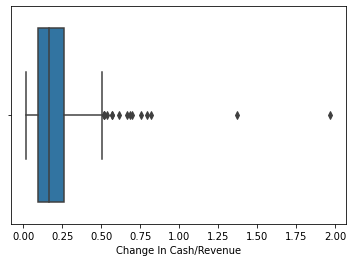

C:\Users\hunte\anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


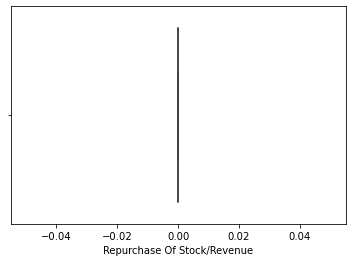

C:\Users\hunte\anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


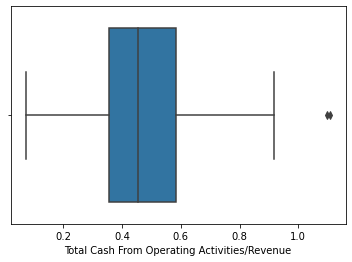

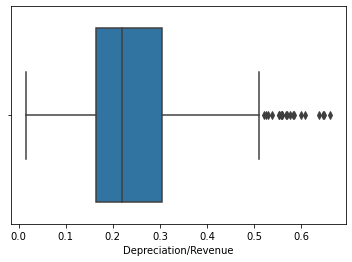

C:\Users\hunte\anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


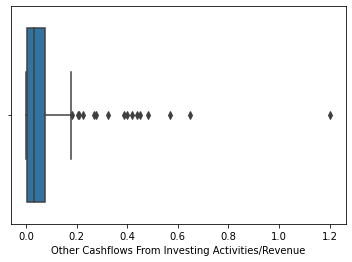

C:\Users\hunte\anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


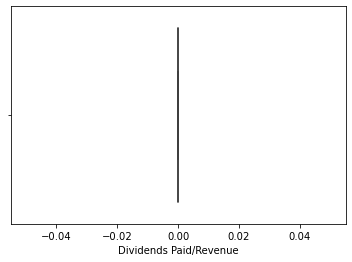

C:\Users\hunte\anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


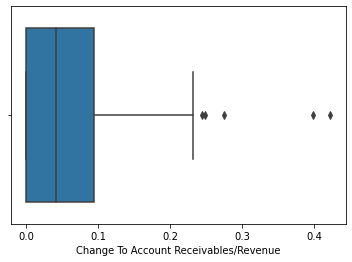

C:\Users\hunte\anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


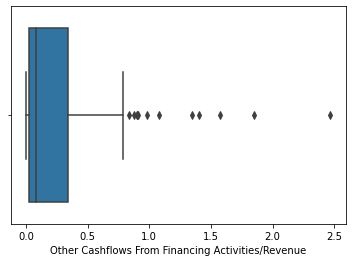

C:\Users\hunte\anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


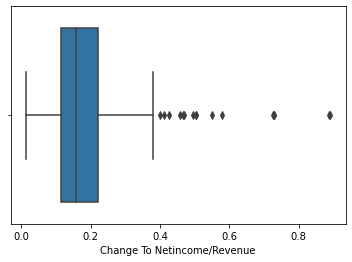

C:\Users\hunte\anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


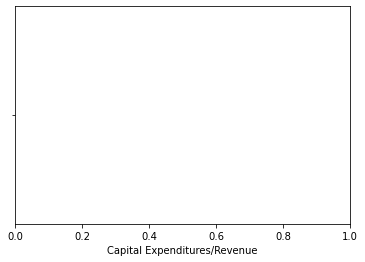

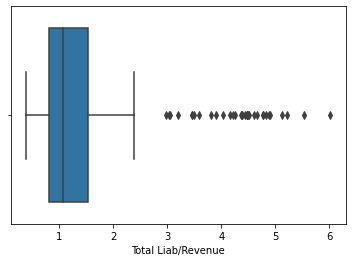

C:\Users\hunte\anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


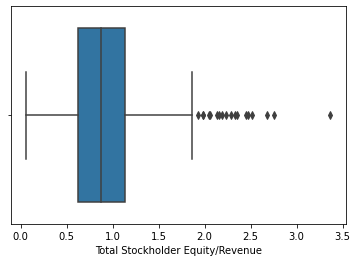

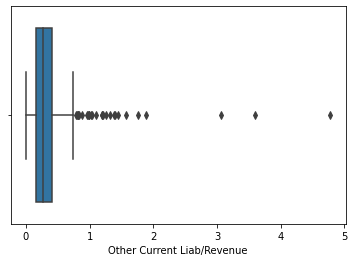

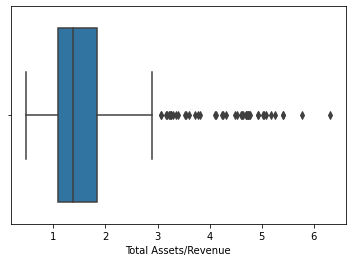

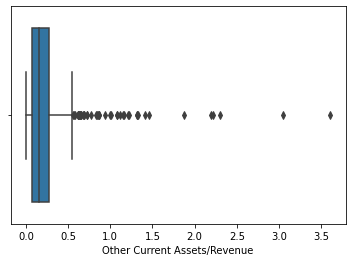

C:\Users\hunte\anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


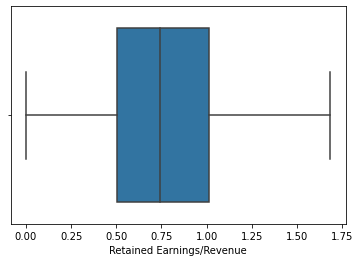

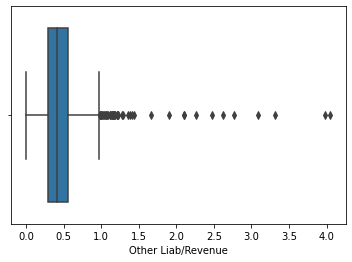

C:\Users\hunte\anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


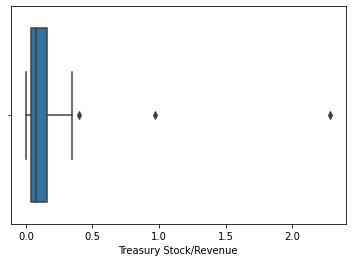

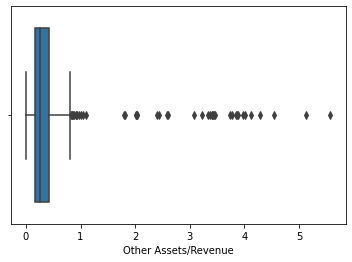

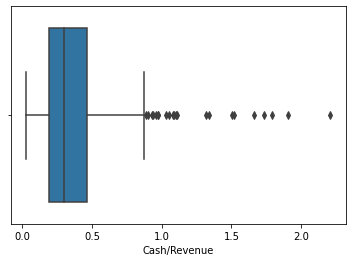

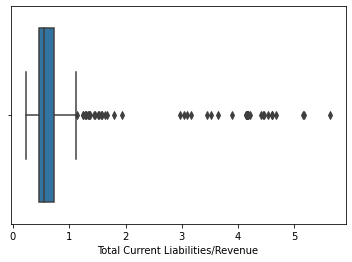

C:\Users\hunte\anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


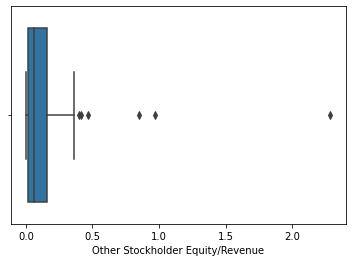

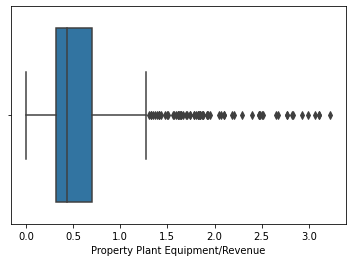

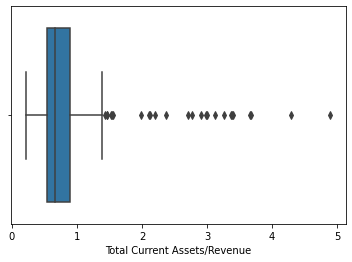

C:\Users\hunte\anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


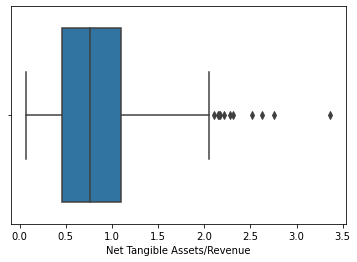

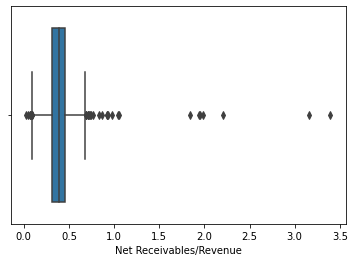

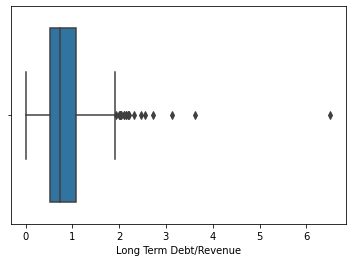

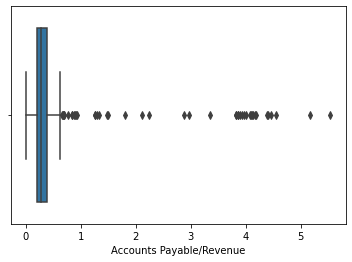

C:\Users\hunte\anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


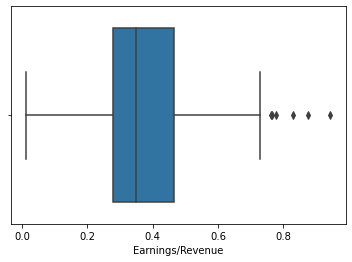

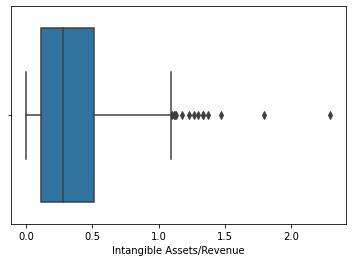

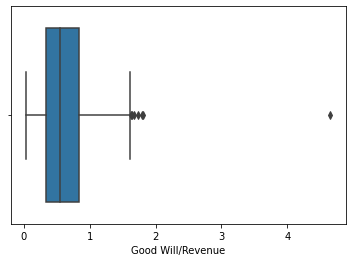

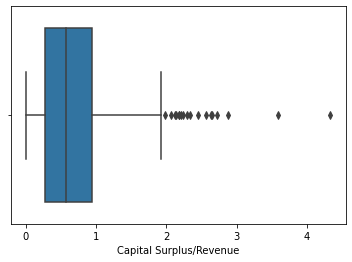

In [79]:
for column in df.columns:
        
    sns.boxplot(x=np.sqrt(df[column]))
    plt.show()

C:\Users\hunte\anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<AxesSubplot:xlabel='Repurchase Of Stock'>

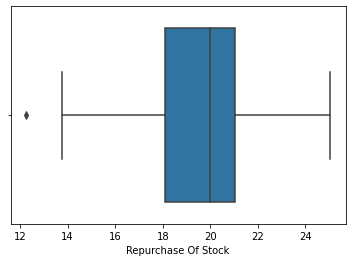

In [80]:
sns.boxplot(x=np.log(df['Repurchase Of Stock']*-1))

C:\Users\hunte\anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\hunte\anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<AxesSubplot:xlabel='Other Cashflows From Investing Activities'>

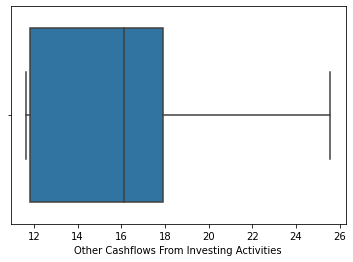

In [81]:
sns.boxplot(x=np.log(df['Other Cashflows From Investing Activities']*-1))

C:\Users\hunte\anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<AxesSubplot:xlabel='Dividends Paid'>

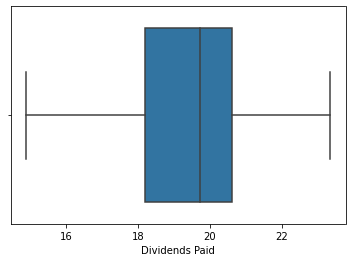

In [82]:
sns.boxplot(x=np.log(df['Dividends Paid']*-1))

<AxesSubplot:xlabel='Capital Expenditures'>

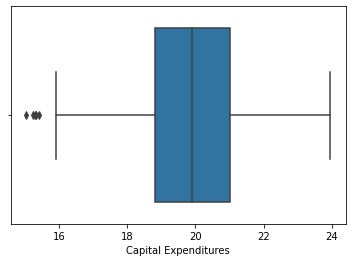

In [83]:
sns.boxplot(x=np.log(df['Capital Expenditures']*-1))

C:\Users\hunte\anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\hunte\anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<AxesSubplot:xlabel='Change To Account Receivables'>

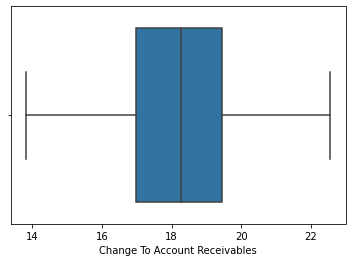

In [84]:
sns.boxplot(x=np.log(df['Change To Account Receivables']*-1))

<AxesSubplot:>

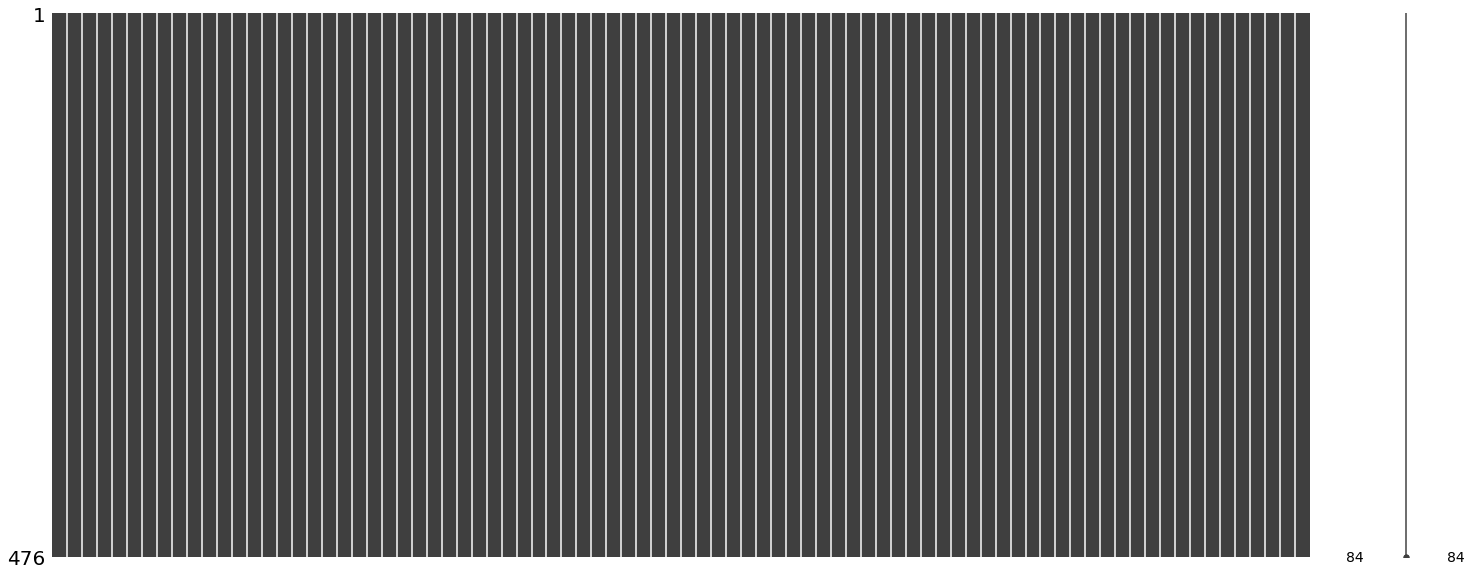

In [85]:
msno.matrix(df)

In [86]:
df

,volatility,Investments,Change To Liabilities,Total Cashflows From Investing Activities,Net Borrowings,Total Cash From Financing Activities,Change To Operating Activities,Net Income,Change In Cash,Repurchase Of Stock,...,Property Plant Equipment/Revenue,Total Current Assets/Revenue,Net Tangible Assets/Revenue,Net Receivables/Revenue,Long Term Debt/Revenue,Accounts Payable/Revenue,Earnings/Revenue,Intangible Assets/Revenue,Good Will/Revenue,Capital Surplus/Revenue
0,2.369968,3.084500e+10,9.172000e+09,1.606600e+10,4.320000e+08,-8.787600e+10,3.001600e+10,5.953100e+10,5.624000e+09,-7.526500e+10,...,0.155515,0.494509,0.403423,0.184473,0.352925,0.210426,0.224142,0.000000,0.011006,0.000000
1,7.524141,5.400000e+08,4.694000e+09,-1.577300e+10,-4.000000e+09,-3.688700e+10,-1.542000e+09,3.924000e+10,-5.900000e+08,-1.954300e+10,...,0.348498,1.395008,0.417616,0.234610,0.529724,0.074553,0.311817,0.061585,0.333956,0.000000
2,2.636179,-1.972000e+09,1.438000e+09,-2.850400e+10,-6.100000e+07,-1.317900e+10,7.890000e+09,3.073600e+10,5.986000e+09,-9.075000e+09,...,0.436482,0.991646,1.151302,0.154898,0.028870,0.031998,0.224647,0.016226,0.130742,0.000000
3,2.542476,-1.972000e+09,1.438000e+09,-2.850400e+10,-6.100000e+07,-1.317900e+10,7.890000e+09,3.073600e+10,5.986000e+09,-9.075000e+09,...,0.436482,0.991646,1.151302,0.154898,0.028870,0.031998,0.224647,0.016226,0.130742,0.000000
4,11.836587,1.140000e+09,4.414000e+09,-1.236900e+10,-7.686000e+09,-7.686000e+09,4.720000e+08,1.007300e+10,1.031700e+10,0.000000e+00,...,0.265352,0.322478,0.106880,0.069815,0.100886,0.163994,0.043253,0.017648,0.062468,0.115039
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
471,3.733131,-6.959500e+06,2.900000e+07,-6.090000e+08,7.000000e+06,-8.720000e+08,1.280000e+08,6.440000e+08,-1.020000e+08,-2.110000e+08,...,0.212888,0.246279,-0.198534,0.027725,0.433557,0.053713,0.048652,0.031049,0.101836,0.058246
472,0.672664,3.723600e+07,2.650000e+06,-1.922470e+08,-5.762000e+07,-2.413090e+08,2.422000e+07,2.419070e+08,8.313200e+07,-9.580000e+05,...,6.297712,0.500793,2.379955,0.155955,3.462230,0.191683,0.265238,0.016759,3.205059,3.294207
473,1.099194,-2.870000e+07,2.100000e+07,-6.343000e+08,8.262000e+08,-6.800000e+06,-2.950000e+07,3.896000e+08,-5.230000e+07,-7.086000e+08,...,0.148293,0.307396,-0.209458,0.104228,0.329803,0.083681,0.071029,0.227307,0.379264,0.504275
474,0.420448,-6.959500e+06,1.240000e+08,-3.078000e+09,-1.661000e+09,-4.023000e+09,-1.930000e+08,-1.733000e+09,-6.900000e+07,-1.000000e+09,...,1.169531,0.169176,-0.840655,0.112135,1.559477,0.085607,-0.076749,0.477369,1.241408,1.012046


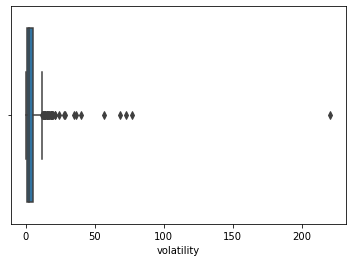

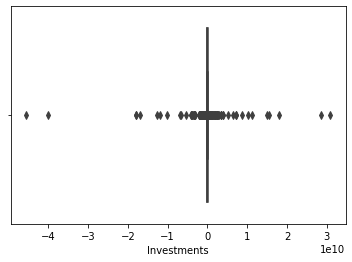

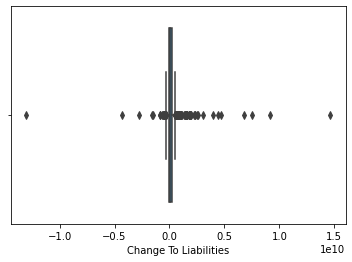

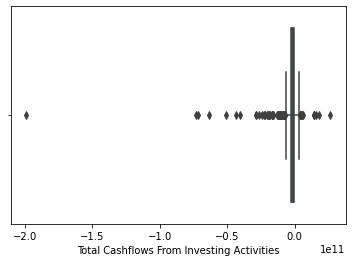

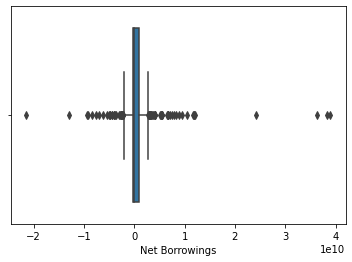

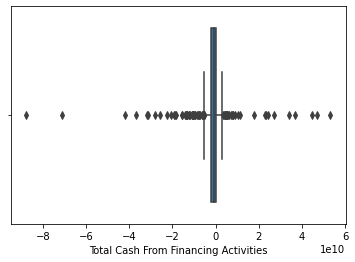

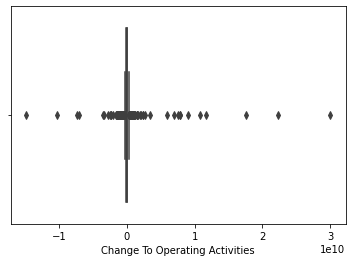

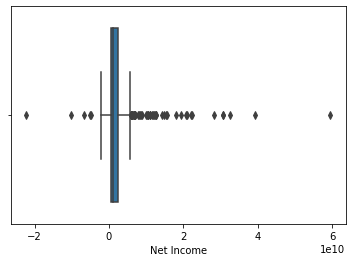

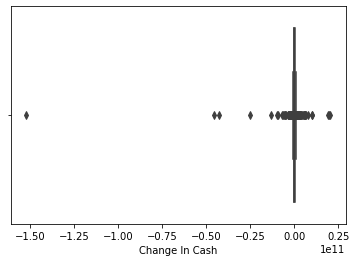

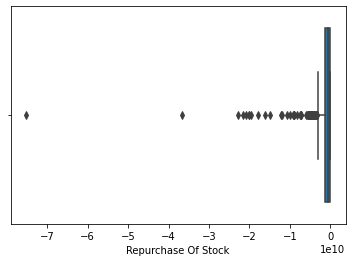

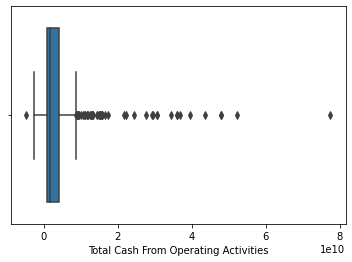

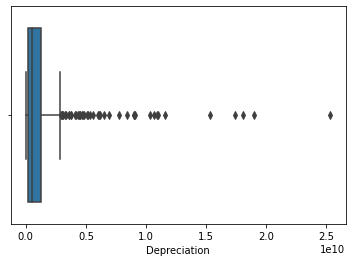

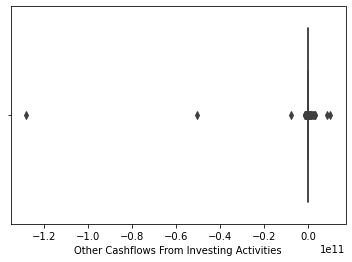

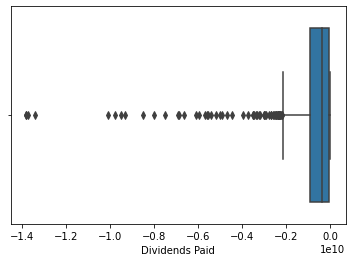

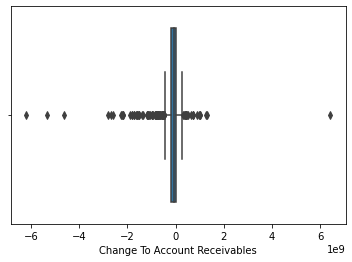

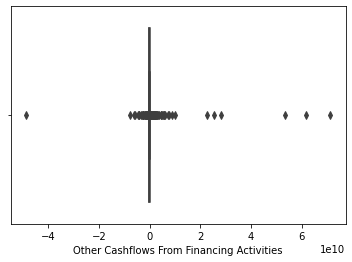

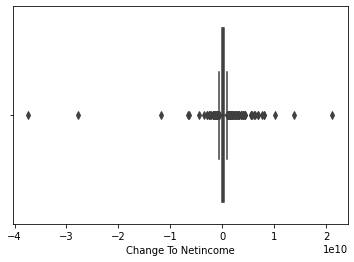

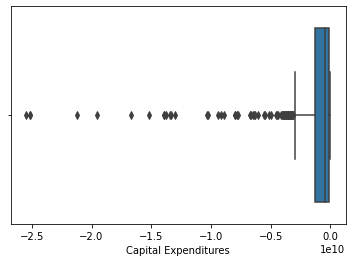

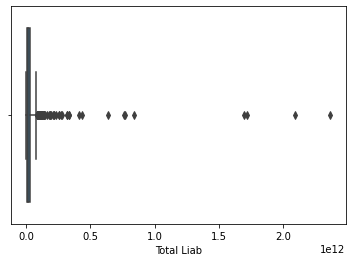

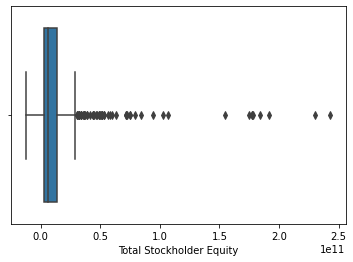

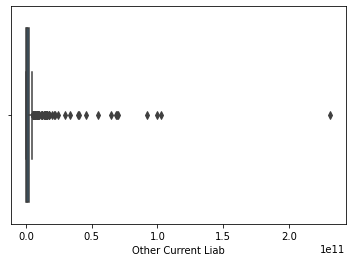

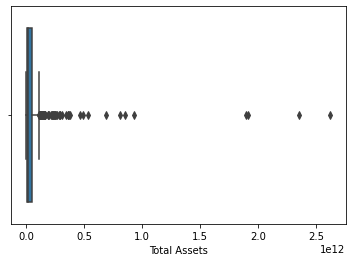

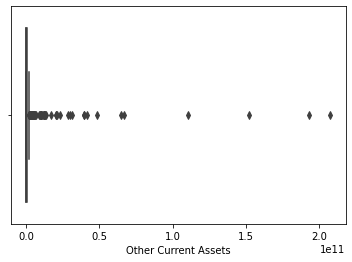

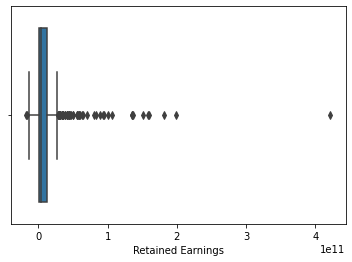

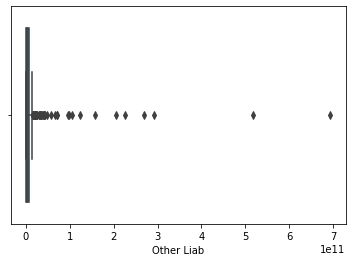

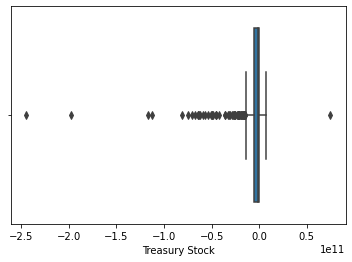

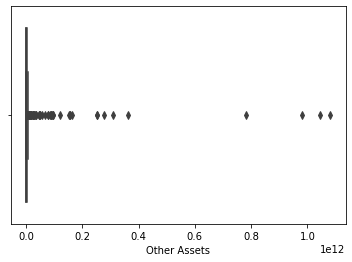

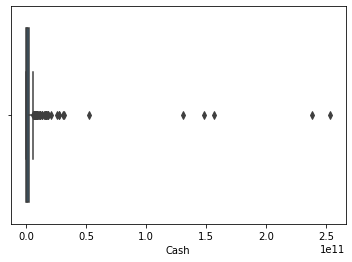

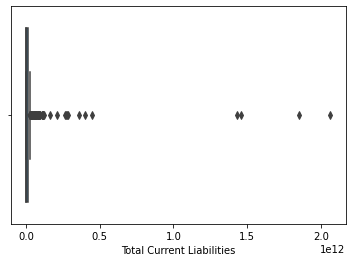

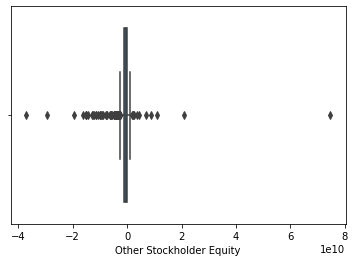

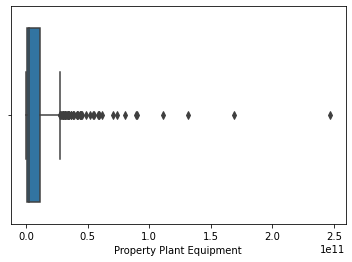

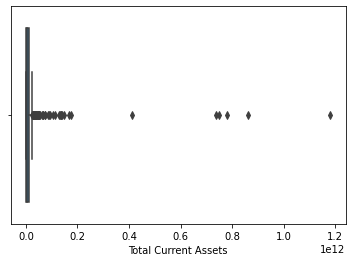

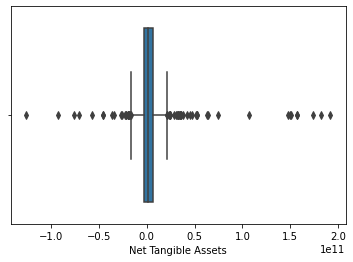

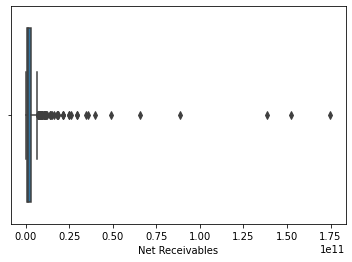

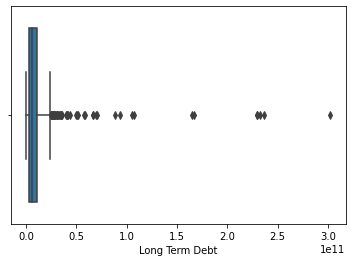

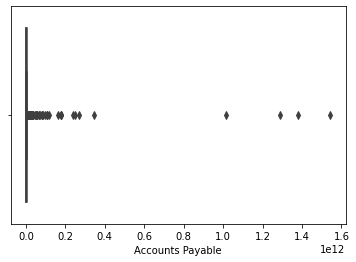

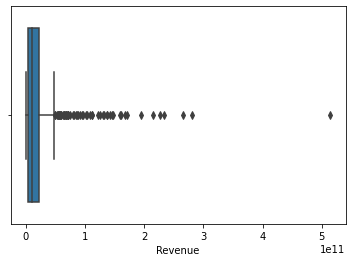

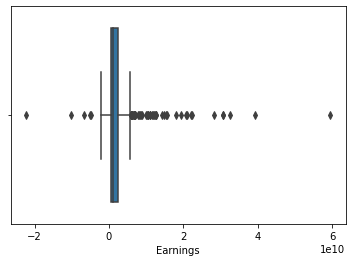

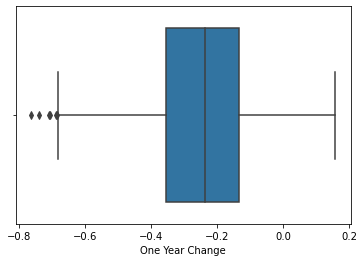

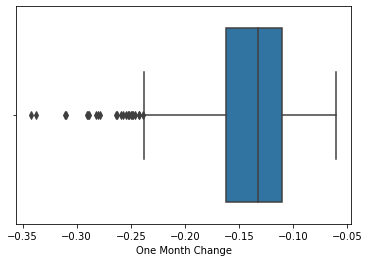

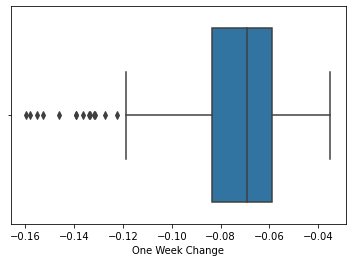

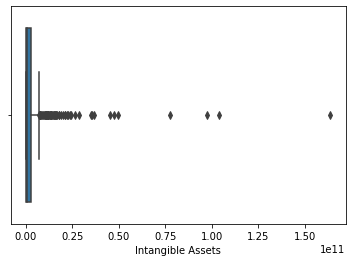

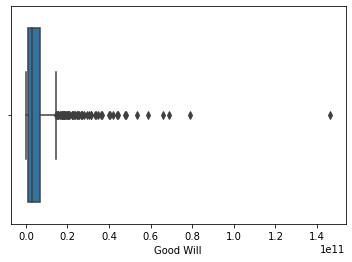

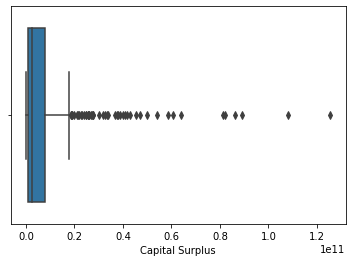

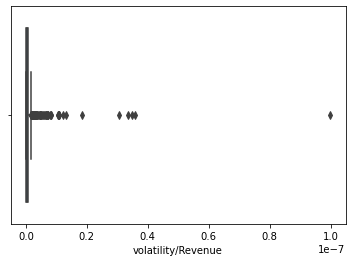

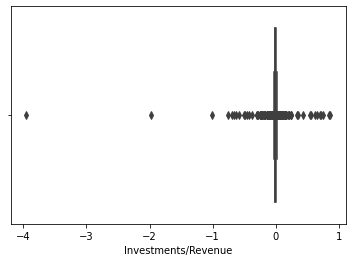

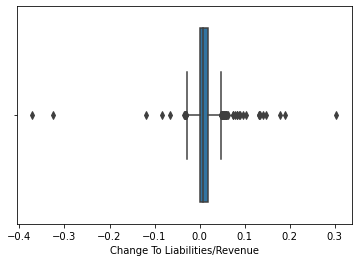

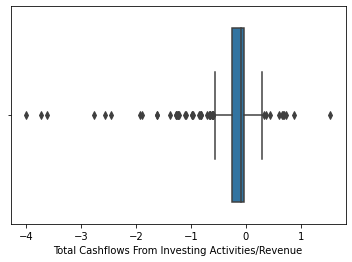

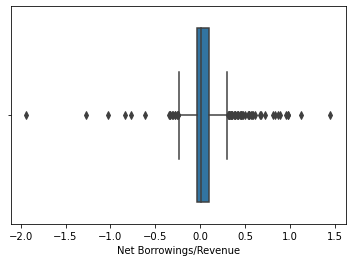

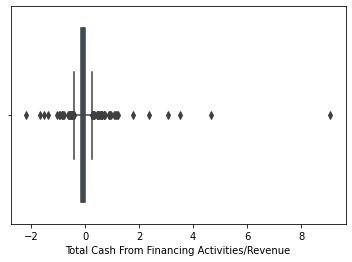

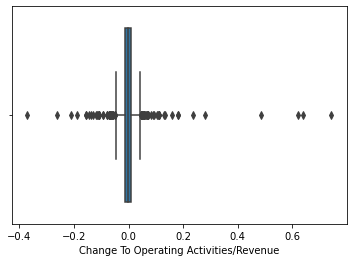

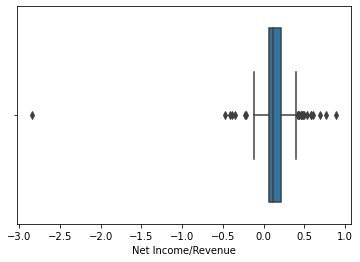

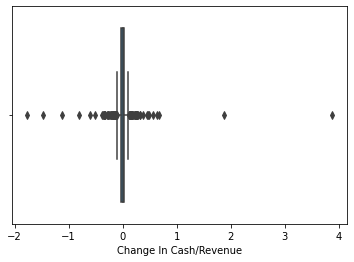

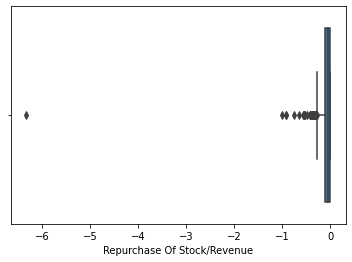

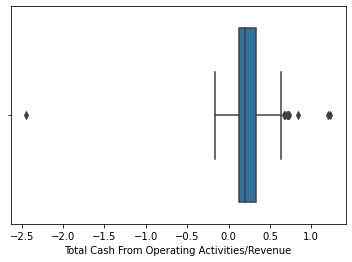

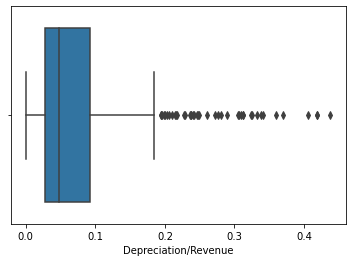

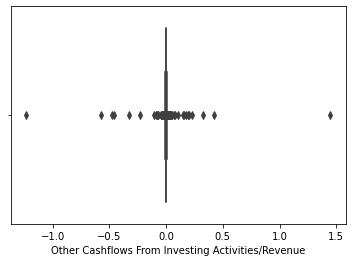

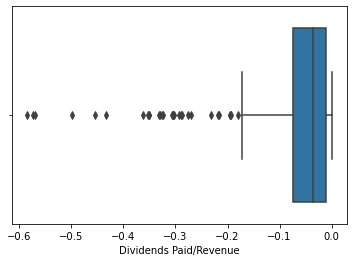

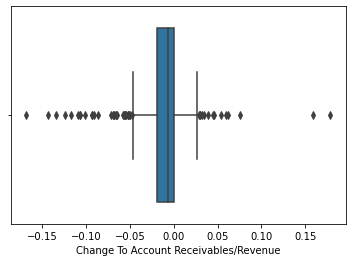

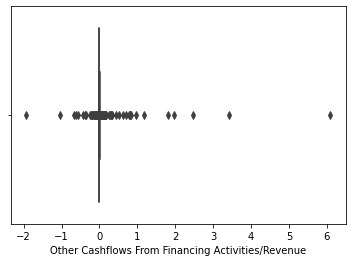

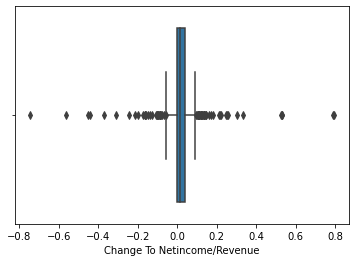

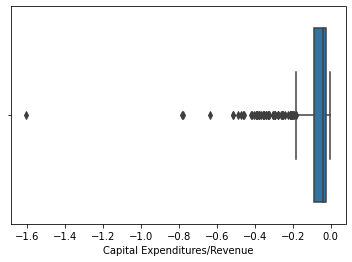

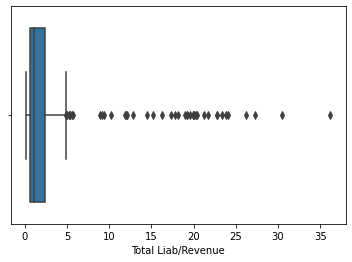

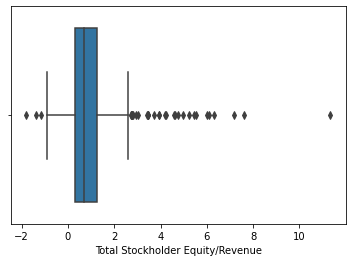

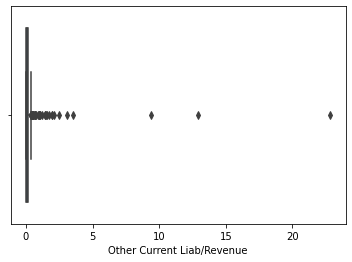

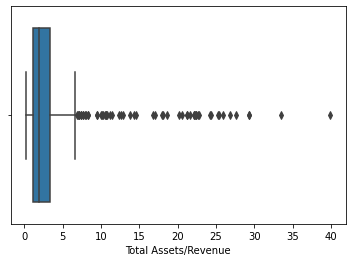

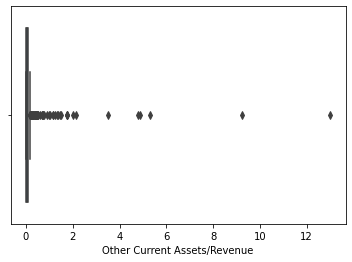

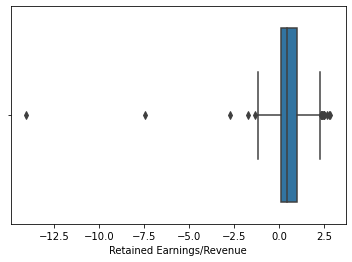

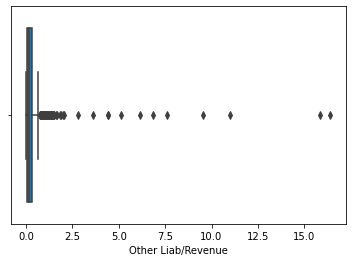

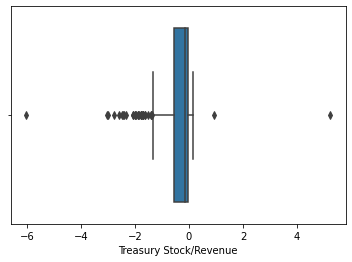

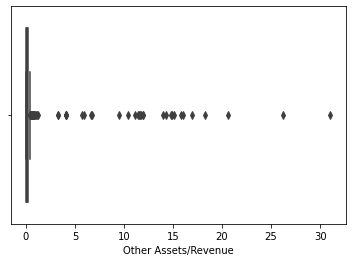

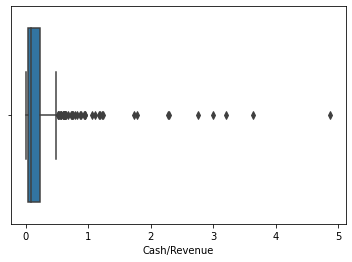

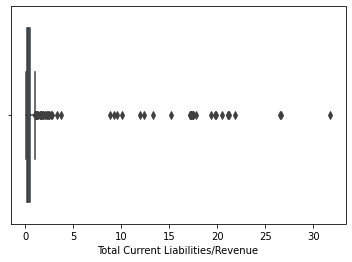

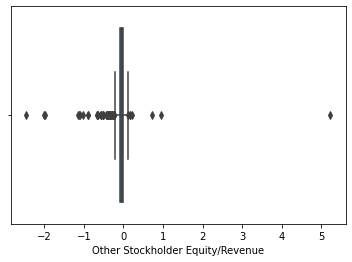

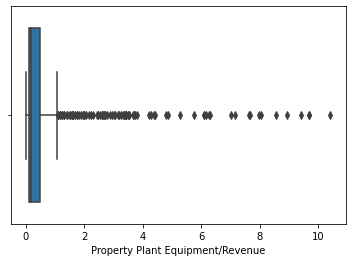

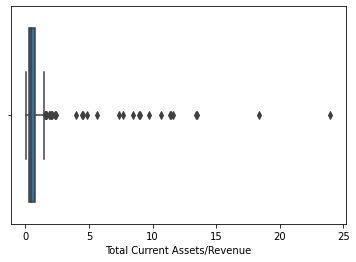

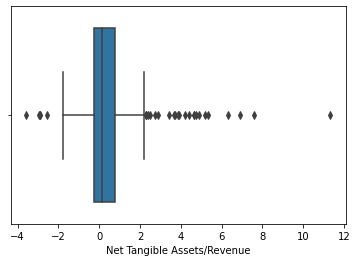

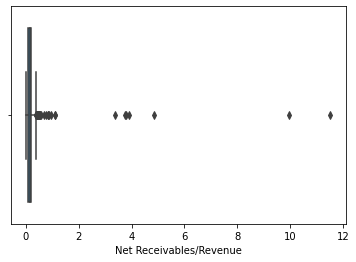

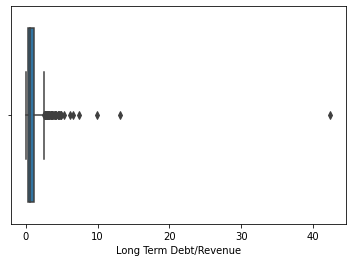

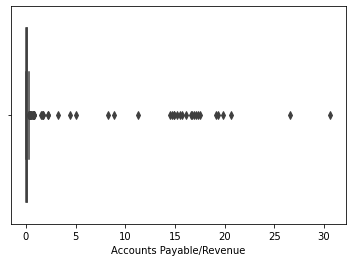

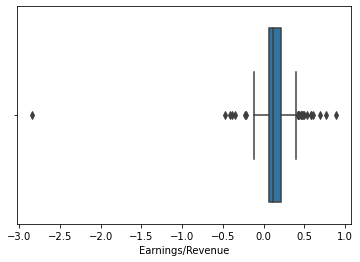

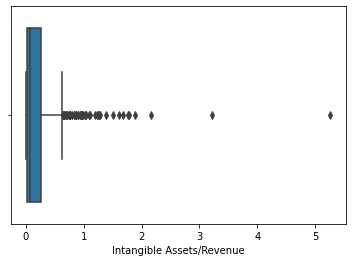

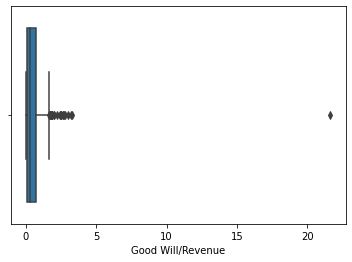

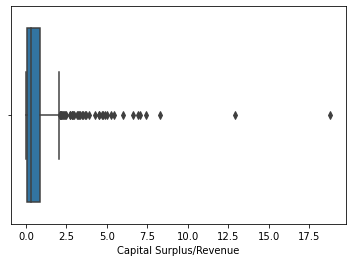

In [87]:
for column in df.columns:
        
    sns.boxplot(x=df[column])
    plt.show()

In [88]:
df.corr()['One Week Change'][0:50]

volatility                                          -0.073288
Investments                                          0.076841
Change To Liabilities                                0.055235
Total Cashflows From Investing Activities           -0.004781
Net Borrowings                                       0.033339
Total Cash From Financing Activities                -0.071622
Change To Operating Activities                      -0.028064
Net Income                                           0.122021
Change In Cash                                      -0.003414
Repurchase Of Stock                                 -0.062416
Total Cash From Operating Activities                 0.087479
Depreciation                                         0.060912
Other Cashflows From Investing Activities           -0.011651
Dividends Paid                                      -0.189716
Change To Account Receivables                       -0.098717
Other Cashflows From Financing Activities           -0.035041
Change T

## Factor Analysis

In [89]:
from sklearn.preprocessing import StandardScaler
from factor_analyzer import FactorAnalyzer # code derived from R package psych
from sklearn.decomposition import FactorAnalysis, PCA
import matplotlib.pyplot as plt
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer.factor_analyzer import calculate_kmo

In [90]:
features = df.drop(columns = ['One Year Change','One Month Change','One Week Change'])

In [91]:
df['Net Borrowings']

0      4.320000e+08
1     -4.000000e+09
2     -6.100000e+07
3     -6.100000e+07
4     -7.686000e+09
           ...     
471    7.000000e+06
472   -5.762000e+07
473    8.262000e+08
474   -1.661000e+09
475    2.442450e+08
Name: Net Borrowings, Length: 476, dtype: float64

In [92]:
transformed_data = StandardScaler().fit_transform(features)

In [93]:
kmo_all,kmo_model=calculate_kmo(transformed_data)
kmo_model

C:\Users\hunte\anaconda3\lib\site-packages\factor_analyzer\utils.py:244: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn(


0.6295181739277155

In [94]:
fa = FactorAnalyzer()
fa.fit(transformed_data)
# Check Eigenvalues
ev, v = fa.get_eigenvalues()

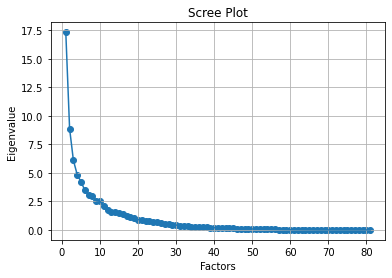

In [95]:
# Create scree plot using matplotlib
plt.scatter(range(1,transformed_data.shape[1]+1),ev)
plt.plot(range(1,transformed_data.shape[1]+1),ev)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

In [96]:
fa = FactorAnalyzer(rotation="varimax", n_factors=25)
fa.fit(transformed_data, 2, )

FactorAnalyzer(n_factors=25, rotation='varimax', rotation_kwargs={})

In [97]:
analysis = pd.DataFrame(fa.loadings_,index=features.columns)

In [98]:
analysis

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
volatility,-0.018142,-0.047840,0.001099,-0.035756,-0.109521,0.008535,-0.005622,-0.001474,0.005036,-0.023254,...,-0.021584,-0.004995,-0.021089,0.562859,-0.033374,-0.010276,0.005933,0.031740,-0.019388,0.002372
Investments,-0.362068,0.074699,0.029277,-0.095675,-0.001586,-0.239565,0.016806,0.067643,-0.044728,-0.033668,...,-0.714186,-0.026253,-0.005381,0.001091,0.046514,0.060014,-0.021889,0.007668,0.001071,-0.014733
Change To Liabilities,0.238028,0.310607,0.014645,-0.019218,-0.048497,-0.017142,0.021537,-0.004418,-0.032927,-0.149255,...,-0.058871,0.037148,-0.297750,-0.022133,-0.118390,0.718745,-0.014607,-0.012825,-0.038931,0.135559
Total Cashflows From Investing Activities,-0.692778,-0.305792,0.021124,-0.083570,0.002399,-0.195746,-0.169147,0.021491,-0.017955,-0.019557,...,-0.184113,-0.220742,0.398759,0.010324,-0.001452,-0.089156,0.091688,0.024997,0.046878,-0.095712
Net Borrowings,0.402569,0.005634,-0.004505,0.002987,-0.027234,-0.049601,0.182475,-0.068927,0.038066,-0.022060,...,-0.004639,0.619766,-0.128611,-0.022495,0.059715,0.060912,-0.049440,-0.069128,-0.121679,0.172285
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Accounts Payable/Revenue,0.279454,0.000119,0.022614,0.940239,-0.041358,-0.002712,-0.015869,-0.019379,-0.028213,0.038201,...,-0.024191,0.040086,0.004437,-0.009146,0.029359,-0.023394,-0.005563,0.049041,-0.058276,0.016475
Earnings/Revenue,0.038634,-0.004772,-0.567403,0.188227,0.121596,0.035670,-0.000491,-0.137211,0.052348,0.118023,...,-0.034797,-0.048731,0.010892,0.100455,0.013942,0.041974,0.004122,0.076982,0.022548,0.044662
Intangible Assets/Revenue,-0.036780,-0.053841,0.048360,-0.013079,0.010169,-0.005325,0.372204,-0.005736,0.348722,-0.048897,...,-0.053126,0.142625,0.000905,-0.036823,-0.012902,0.014444,-0.010067,0.004725,0.684588,0.021210
Good Will/Revenue,-0.022324,-0.073252,0.875619,0.027951,0.193975,-0.026410,0.086834,-0.048746,0.078593,-0.012422,...,0.013053,0.006119,-0.059189,-0.056006,0.015158,-0.058646,-0.028652,-0.025110,0.185474,0.086026


In [99]:
totals = pd.DataFrame(analysis[0]*0)

for column in analysis.columns:
    
    totals[0] += analysis[column].abs()
    
    
    

In [100]:
worst_features = []
x = 0
for feature in totals.index:

    if totals.iloc[x][0] < 2.6:
        worst_features.append(feature)
        
    x+= 1
        

In [101]:
len(worst_features)

54

In [102]:
worst_features

['volatility',
 'Investments',
 'Net Borrowings',
 'Change To Operating Activities',
 'Depreciation',
 'Change To Account Receivables',
 'Change To Netincome',
 'Capital Expenditures',
 'Total Liab',
 'Total Stockholder Equity',
 'Total Assets',
 'Retained Earnings',
 'Other Liab',
 'Treasury Stock',
 'Other Assets',
 'Cash',
 'Total Current Liabilities',
 'Other Stockholder Equity',
 'Property Plant Equipment',
 'Total Current Assets',
 'Long Term Debt',
 'Accounts Payable',
 'Revenue',
 'Intangible Assets',
 'Good Will',
 'Capital Surplus',
 'volatility/Revenue',
 'Investments/Revenue',
 'Change To Liabilities/Revenue',
 'Net Borrowings/Revenue',
 'Change To Operating Activities/Revenue',
 'Change In Cash/Revenue',
 'Repurchase Of Stock/Revenue',
 'Depreciation/Revenue',
 'Other Cashflows From Investing Activities/Revenue',
 'Dividends Paid/Revenue',
 'Change To Account Receivables/Revenue',
 'Other Cashflows From Financing Activities/Revenue',
 'Change To Netincome/Revenue',
 'Capit

In [103]:
print(pd.DataFrame(fa.get_factor_variance(), 
                   index=['sum','proportional','cumulative']))

                     0         1         2         3         4         5   \
sum           12.362212  7.569508  5.692164  5.328150  4.357827  3.108451   
proportional   0.152620  0.093451  0.070274  0.065780  0.053800  0.038376   
cumulative     0.152620  0.246071  0.316344  0.382124  0.435924  0.474300   

                    6         7         8         9   ...        15        16  \
sum           2.510619  2.292335  2.286310  2.203150  ...  1.639510  1.565965   
proportional  0.030995  0.028300  0.028226  0.027199  ...  0.020241  0.019333   
cumulative    0.505295  0.533596  0.561822  0.589021  ...  0.724380  0.743712   

                    17        18        19        20        21        22  \
sum           1.514009  1.408379  1.390843  1.365372  1.159534  1.147233   
proportional  0.018691  0.017387  0.017171  0.016856  0.014315  0.014163   
cumulative    0.762404  0.779791  0.796962  0.813819  0.828134  0.842297   

                    23        24  
sum           0.993537  0.

In [104]:
df = df.drop(columns=worst_features)

In [105]:
df

,Change To Liabilities,Total Cashflows From Investing Activities,Total Cash From Financing Activities,Net Income,Change In Cash,Repurchase Of Stock,Total Cash From Operating Activities,Other Cashflows From Investing Activities,Dividends Paid,Other Cashflows From Financing Activities,...,Net Income/Revenue,Total Cash From Operating Activities/Revenue,Total Stockholder Equity/Revenue,Other Current Liab/Revenue,Total Assets/Revenue,Cash/Revenue,Total Current Assets/Revenue,Net Tangible Assets/Revenue,Earnings/Revenue,Capital Surplus/Revenue
0,9.172000e+09,1.606600e+10,-8.787600e+10,5.953100e+10,5.624000e+09,-7.526500e+10,7.743400e+10,-7.450000e+08,-1.371200e+10,-1.050000e+08,...,0.224142,0.291549,0.403423,0.147943,1.377003,0.097566,0.494509,0.403423,0.224142,0.000000
1,4.694000e+09,-1.577300e+10,-3.688700e+10,3.924000e+10,-5.900000e+08,-1.954300e+10,5.218500e+10,-1.241000e+09,-1.381100e+10,-6.750000e+08,...,0.311817,0.414683,0.813156,0.364422,2.277091,0.090239,1.395008,0.417616,0.311817,0.000000
2,1.438000e+09,-2.850400e+10,-1.317900e+10,3.073600e+10,5.986000e+09,-9.075000e+09,4.797100e+10,9.800000e+07,0.000000e+00,-4.043000e+09,...,0.224647,0.350617,1.298270,0.128725,1.701460,0.122066,0.991646,1.151302,0.224647,0.000000
3,1.438000e+09,-2.850400e+10,-1.317900e+10,3.073600e+10,5.986000e+09,-9.075000e+09,4.797100e+10,9.800000e+07,0.000000e+00,-4.043000e+09,...,0.224647,0.350617,1.298270,0.128725,1.701460,0.122066,0.991646,1.151302,0.224647,0.000000
4,4.414000e+09,-1.236900e+10,-7.686000e+09,1.007300e+10,1.031700e+10,0.000000e+00,3.072300e+10,2.104000e+09,0.000000e+00,0.000000e+00,...,0.043253,0.131922,0.186996,0.042763,0.698399,0.136332,0.322478,0.106880,0.043253,0.115039
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
471,2.900000e+07,-6.090000e+08,-8.720000e+08,6.440000e+08,-1.020000e+08,-2.110000e+08,1.377000e+09,2.000000e+07,-6.660000e+08,-2.000000e+06,...,0.048652,0.104027,-0.065649,0.054846,0.611166,0.106746,0.246279,-0.198534,0.048652,0.058246
472,2.650000e+06,-1.922470e+08,-2.413090e+08,2.419070e+08,8.313200e+07,-9.580000e+05,5.166880e+08,-2.543000e+07,-3.011940e+08,-1.245500e+07,...,0.265238,0.566520,2.396714,0.089149,6.896252,0.070268,0.500793,2.379955,0.265238,3.294207
473,2.100000e+07,-6.343000e+08,-6.800000e+06,3.896000e+08,-5.230000e+07,-7.086000e+08,6.040000e+08,4.000000e+06,-1.152000e+08,-1.410000e+07,...,0.071029,0.110116,0.397112,0.016153,1.087419,0.047930,0.307396,-0.209458,0.071029,0.504275
474,1.240000e+08,-3.078000e+09,-4.023000e+09,-1.733000e+09,-6.900000e+07,-1.000000e+09,7.032000e+09,-6.100000e+07,-2.312000e+09,-5.000000e+07,...,-0.076749,0.311426,0.878122,0.065589,3.111426,0.021612,0.169176,-0.840655,-0.076749,1.012046


In [15]:
df.columns

NameError: name 'df' is not defined

In [16]:
df.corr()['One Year Change']

NameError: name 'df' is not defined

# Training

In [107]:
target_One_Year = df.pop('One Year Change')
target_One_Month = df.pop('One Month Change')
target_One_Week = df.pop('One Week Change')

In [108]:
df

,Change To Liabilities,Total Cashflows From Investing Activities,Total Cash From Financing Activities,Net Income,Change In Cash,Repurchase Of Stock,Total Cash From Operating Activities,Other Cashflows From Investing Activities,Dividends Paid,Other Cashflows From Financing Activities,...,Net Income/Revenue,Total Cash From Operating Activities/Revenue,Total Stockholder Equity/Revenue,Other Current Liab/Revenue,Total Assets/Revenue,Cash/Revenue,Total Current Assets/Revenue,Net Tangible Assets/Revenue,Earnings/Revenue,Capital Surplus/Revenue
0,9.172000e+09,1.606600e+10,-8.787600e+10,5.953100e+10,5.624000e+09,-7.526500e+10,7.743400e+10,-7.450000e+08,-1.371200e+10,-1.050000e+08,...,0.224142,0.291549,0.403423,0.147943,1.377003,0.097566,0.494509,0.403423,0.224142,0.000000
1,4.694000e+09,-1.577300e+10,-3.688700e+10,3.924000e+10,-5.900000e+08,-1.954300e+10,5.218500e+10,-1.241000e+09,-1.381100e+10,-6.750000e+08,...,0.311817,0.414683,0.813156,0.364422,2.277091,0.090239,1.395008,0.417616,0.311817,0.000000
2,1.438000e+09,-2.850400e+10,-1.317900e+10,3.073600e+10,5.986000e+09,-9.075000e+09,4.797100e+10,9.800000e+07,0.000000e+00,-4.043000e+09,...,0.224647,0.350617,1.298270,0.128725,1.701460,0.122066,0.991646,1.151302,0.224647,0.000000
3,1.438000e+09,-2.850400e+10,-1.317900e+10,3.073600e+10,5.986000e+09,-9.075000e+09,4.797100e+10,9.800000e+07,0.000000e+00,-4.043000e+09,...,0.224647,0.350617,1.298270,0.128725,1.701460,0.122066,0.991646,1.151302,0.224647,0.000000
4,4.414000e+09,-1.236900e+10,-7.686000e+09,1.007300e+10,1.031700e+10,0.000000e+00,3.072300e+10,2.104000e+09,0.000000e+00,0.000000e+00,...,0.043253,0.131922,0.186996,0.042763,0.698399,0.136332,0.322478,0.106880,0.043253,0.115039
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
471,2.900000e+07,-6.090000e+08,-8.720000e+08,6.440000e+08,-1.020000e+08,-2.110000e+08,1.377000e+09,2.000000e+07,-6.660000e+08,-2.000000e+06,...,0.048652,0.104027,-0.065649,0.054846,0.611166,0.106746,0.246279,-0.198534,0.048652,0.058246
472,2.650000e+06,-1.922470e+08,-2.413090e+08,2.419070e+08,8.313200e+07,-9.580000e+05,5.166880e+08,-2.543000e+07,-3.011940e+08,-1.245500e+07,...,0.265238,0.566520,2.396714,0.089149,6.896252,0.070268,0.500793,2.379955,0.265238,3.294207
473,2.100000e+07,-6.343000e+08,-6.800000e+06,3.896000e+08,-5.230000e+07,-7.086000e+08,6.040000e+08,4.000000e+06,-1.152000e+08,-1.410000e+07,...,0.071029,0.110116,0.397112,0.016153,1.087419,0.047930,0.307396,-0.209458,0.071029,0.504275
474,1.240000e+08,-3.078000e+09,-4.023000e+09,-1.733000e+09,-6.900000e+07,-1.000000e+09,7.032000e+09,-6.100000e+07,-2.312000e+09,-5.000000e+07,...,-0.076749,0.311426,0.878122,0.065589,3.111426,0.021612,0.169176,-0.840655,-0.076749,1.012046


In [109]:
from sklearn.model_selection import train_test_split

In [110]:
X_train, X_test, y_train, y_test = train_test_split(df, target_One_Week, test_size=0.1, random_state=42)

In [111]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import  RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import VarianceThreshold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer, StandardScaler, MinMaxScaler, PowerTransformer, MaxAbsScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

In [112]:
pca = PCA()
logistic = LogisticRegression(max_iter=10000, tol=0.1)

# Linear Regression

In [113]:
pipe = Pipeline([('scaler', StandardScaler()), (('selector', VarianceThreshold())),('classifier', LinearRegression())])

In [116]:
parameters = {'scaler': [StandardScaler(), MinMaxScaler(),Normalizer(), MaxAbsScaler()],'selector__threshold': [0, 0.001, 0.01]}

In [117]:
grid = GridSearchCV(pipe, parameters, cv=10).fit(X_train, y_train)

In [118]:
print('Training set score: ' + str(grid.score(X_train,y_train)))
print('Test set score: ' + str(grid.score(X_test,y_test)))

Training set score: 0.2934740281640832
Test set score: 0.11836467733194789


# DecisionTree Regressor

In [119]:
from sklearn.tree import DecisionTreeRegressor

In [120]:
pipe = Pipeline([('scaler', StandardScaler()), (('selector', VarianceThreshold())),("regressor", DecisionTreeRegressor())])

In [121]:
parameters = {'scaler': [StandardScaler(), MinMaxScaler(),Normalizer(), MaxAbsScaler()],'selector__threshold': [0, 0.001, 0.01]}


In [122]:
grid = GridSearchCV(pipe, parameters, cv=10).fit(X_train, y_train)

In [123]:
print('Training set score: ' + str(grid.score(X_train,y_train)))
print('Test set score: ' + str(grid.score(X_test,y_test)))

Training set score: 0.9999980556092513
Test set score: -0.282507573991686


# Random Forest

In [128]:
pipe = Pipeline([('scaler', StandardScaler()), (('selector', VarianceThreshold())),("regressor", RandomForestRegressor())])

In [19]:
parameters = {'scaler': [StandardScaler(), MinMaxScaler(),Normalizer(), MaxAbsScaler()],'selector__threshold': [0, 0.001, 0.01]}


NameError: name 'MinMaxScaler' is not defined

In [130]:
grid = GridSearchCV(pipe, parameters, cv=10).fit(X_train, y_train)

In [131]:
print('Training set score: ' + str(grid.score(X_train,y_train)))
print('Test set score: ' + str(grid.score(X_test,y_test)))

Training set score: 0.9007881324133543
Test set score: 0.18373844890723234


# Main Function

In [140]:
test_ticker = X_test.iloc[0].to_numpy().reshape(1, -1)

In [141]:
grid.predict(test_ticker)

array([-0.06649061])

Worst case senario shows a possible 6 percent drop in a week. 

# Personal Contribution Statement

This weeks tasks were difficult. After cleaning and working with the data, it became clear that attributes did not have nearly the predictive values that I had thought they would have for the target. I tried a few different models, but I may need to find different attributes since most of my attributes have a correlation below .1. However, all work is my own as this is a indvidual project. It took a lot of time an effort to pull, transform and clean the data. It just so happened that the data didn't have great prediction value. Which sometimes happens even in the real world. I am proud of my self for trying something novel, but will take more work to get a worthy model to put into a website.